In [ ]:
#!pip install tensorflow-gpu

# Home Facial Recognition Security System
## Group members:


1.   Vikneswari A/P Perumal 
2.   Andre Lim Tong En
3.   Liew Zi Feng
4.   Yong Yung Jun










# **PART A** 

##Problem Statement


> Nowadays, the society's awareness regarding the security aspects of their housing area is increasing drastically due to the increasing occurrence and severity of crimes such as robbery, snatch theif, burglary and kidnapping. This has raised security concerns and anxieties of the public. With the advancement of technology, facial recognition features has been one of the options for home security systems that allows only faces which are loaded into the system to have access to the property. Thus, the accuracy to identify the right person is very crucial in order to acheive satisfactory security and convenience. Thus, in our project a dataset is loaded and underwent preprocessing, several models are tested to identify which model can best do the job.



## Load Dataset from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


###Brief information about dataset used :


*   There are ten different image of each of 46 distinct people
*   There are 460 face images in the dataset
*   Face images were taken at different times, variying ligthing, facial express and facial detail  
*   Size of each image is 64x64
*   Dataset is uploaded to Google Drive

Steps to loads the dataset from Google Drive

1.   Unzip the Dataset.rar file 
2.   Upload Dataset folder to your Google Drive (My Drive)
3.   Connect your Google Drive with Google Colab


   


##Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os, sys
import cv2
import numpy as np
from matplotlib import image
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
from skimage import color
from skimage import io
import matplotlib.image as mpimg
import keras
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from numpy import argmax
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn import metrics
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
path = "/content/gdrive/MyDrive/Dataset/MLdatax11/"
dirs = os.listdir( path )
dirs = sorted(dirs,key=lambda x: int(os.path.splitext(x)[0]))
x_train=[]

if __name__ == "__main__":
    
    for item in dirs: 
        if os.path.isfile(path+item):
            im = Image.open(path+item).convert("L") #convert images to grayscale
            im.thumbnail((64,64)) #shrinking images
            im = np.array(im)
            x_train.append(im)

    imgset = np.array(x_train)
    np.save("/content/image_data.npy",imgset) #save temporarily in npy file

    dfTarget = pd.read_excel("/content/gdrive/MyDrive/Dataset/MLx13.xlsx", header=None)
    dfTarget2 = np.array(dfTarget)
    np.save("/content/image_target.npy",dfTarget2)

In [ ]:
data=np.load("/content/image_data.npy", allow_pickle=True)
target=np.load("/content/image_target.npy", allow_pickle=True)  

##Verifying details of dataset used

In [ ]:
print("There are {} images in the dataset".format(len(data)))
print("There are {} unique targets in the dataset".format(len(np.unique(target))))
print("Size of each image is {}x{}".format(data.shape[1],data.shape[2]))
print("Pixel values were scaled to [0,1] interval. e.g:{}".format(data[0][0,:4]))


There are 460 images in the dataset
There are 46 unique targets in the dataset
Size of each image is 64x64
Pixel values were scaled to [0,1] interval. e.g:[241 242 242 242]


##Examine the images in the dataset

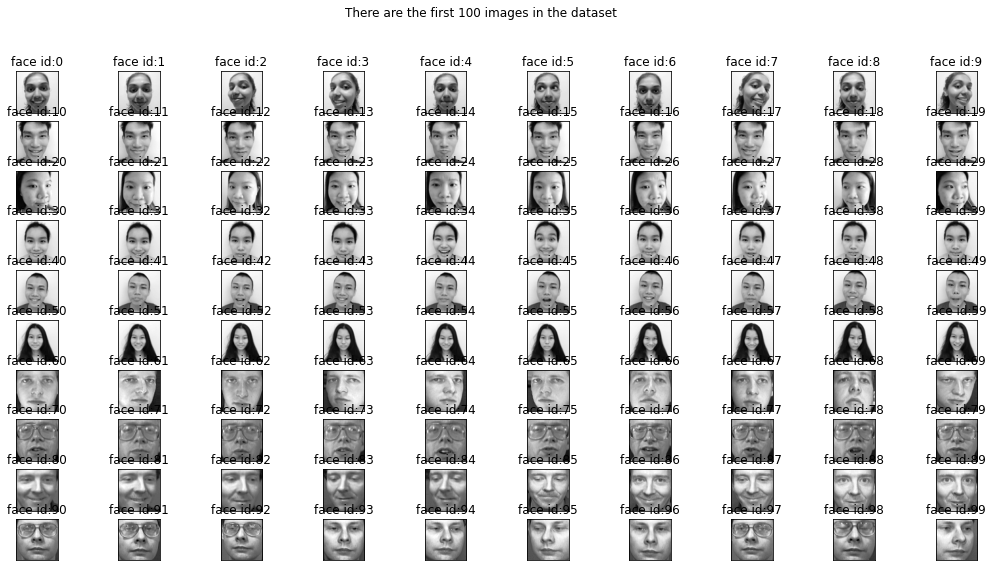

In [ ]:
def show_people(images):
    fig, axarr=plt.subplots(nrows=10, ncols=10, figsize=(18, 9))
    axarr=axarr.flatten()
    
    for id in range(100):
        image_index=id
        axarr[id].imshow(images[image_index].astype(int), cmap=plt.get_cmap('gray'))
        axarr[id].set_xticks([])
        axarr[id].set_yticks([])
        axarr[id].set_title("face id:{}".format(id))
    plt.suptitle("There are the first 100 images in the dataset")

show_people(data)

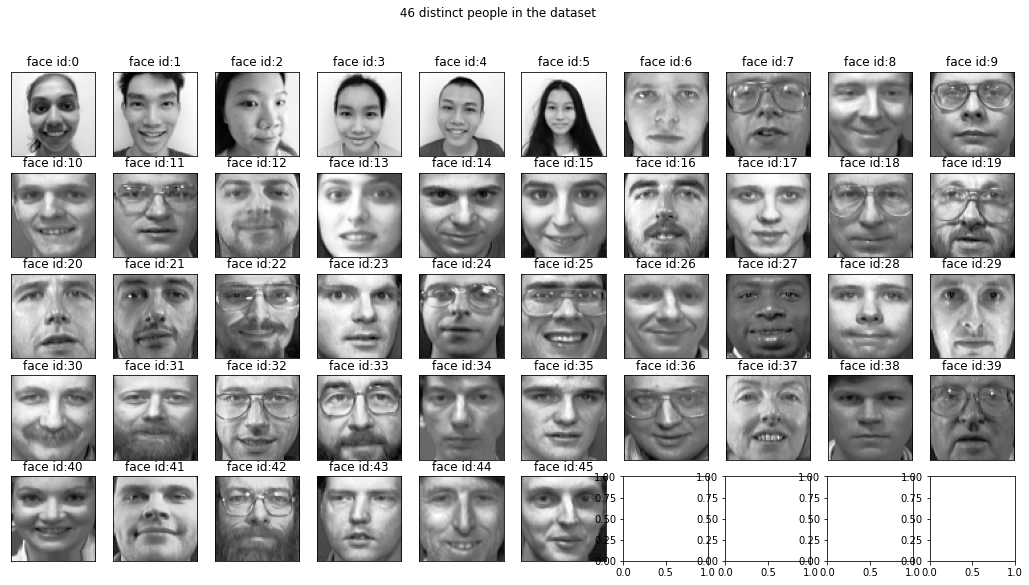

In [ ]:
def show_distinct_people(images):
    fig, axarr=plt.subplots(nrows=5, ncols=10, figsize=(18, 9))  #4x5 subplots in a figure size of 18x9
    axarr=axarr.flatten() # Flattened 4X5 subplots matrix to 40 array for easy iteration
    
    # iterating through the user ids
    for unique_id in range(len(np.unique(target))): 
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index].astype(int),cmap=plt.get_cmap('gray'))
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
    plt.suptitle(" " + str(len(np.unique(target))) + " distinct people in the dataset")

show_distinct_people(data)

##Machine Learning Model fo Face Recognition

In [ ]:
# The image data is in matrix form and converted to a vector
X=data.reshape((data.shape[0],data.shape[1]*data.shape[2])) # reshaping images
print("X shape:",X.shape) 

X shape: (460, 4096)


##Splitting data and the target into subsets for random training and testing.

In [ ]:
# 70% will be used for training, while 30% will be used for testing
# stratify feature is used to ensure that each subject has an equal number of training and test images

X_train, X_test, y_train, y_test=train_test_split(X, target, test_size=0.3, stratify=target, random_state=0)
print("X_train shape:",X_train.shape)
print("y_train shape:{}".format(y_train.shape))

X_train shape: (322, 4096)
y_train shape:(322, 1)


##Feature Extraction

###Principle Component Analysis

> The data will be transformed with the help of unsupervised learning.
Projection of a defined number of targets using PCA.



In [ ]:
pca=PCA(n_components=2) # converts four-dimensional data into two-dimensional data (dimensionality reduction)
pca.fit(X)
X_pca=pca.transform(X) # Apply dimensionality reduction, The first principal components extracted from a training set are projected onto X.

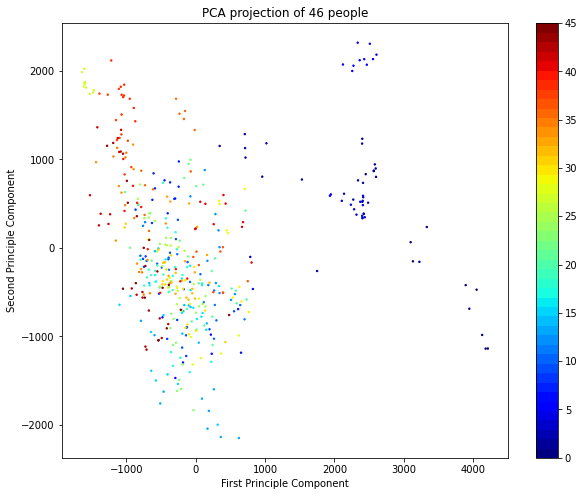

In [ ]:
number_of_people=len(np.unique(target))
index_range=number_of_people*len(np.unique(target))
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)
scatter=ax.scatter(X_pca[:index_range,0],
            X_pca[:index_range,1], 
            c=target[:index_range],
            s=2,
           cmap=plt.get_cmap('jet', number_of_people)
          )

ax.set_xlabel("First Principle Component")
ax.set_ylabel("Second Principle Component")
ax.set_title("PCA projection of {} people".format(number_of_people))

fig.colorbar(scatter)

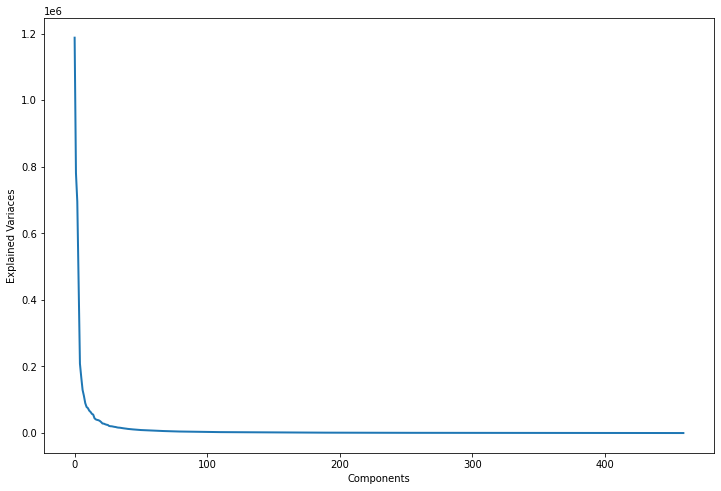

In [ ]:
# Identify the optimum number of components
pca=PCA()
pca.fit(X)

plt.figure(1, figsize=(12,8))

plt.plot(pca.explained_variance_, linewidth=2) # The number of variance explained by each of the chosen components
 
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

> Diagram above shows that 100 or more PCA components represent the same data





In [ ]:
n_components=100 # 100 PCA components   
pca=PCA(n_components=n_components, whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

###Display Eigen Faces


>  The lighter the region, the more variation there is, while the darker the region, the less variation there is.



Text(0.5, 0.98, 'All Eigen Faces')

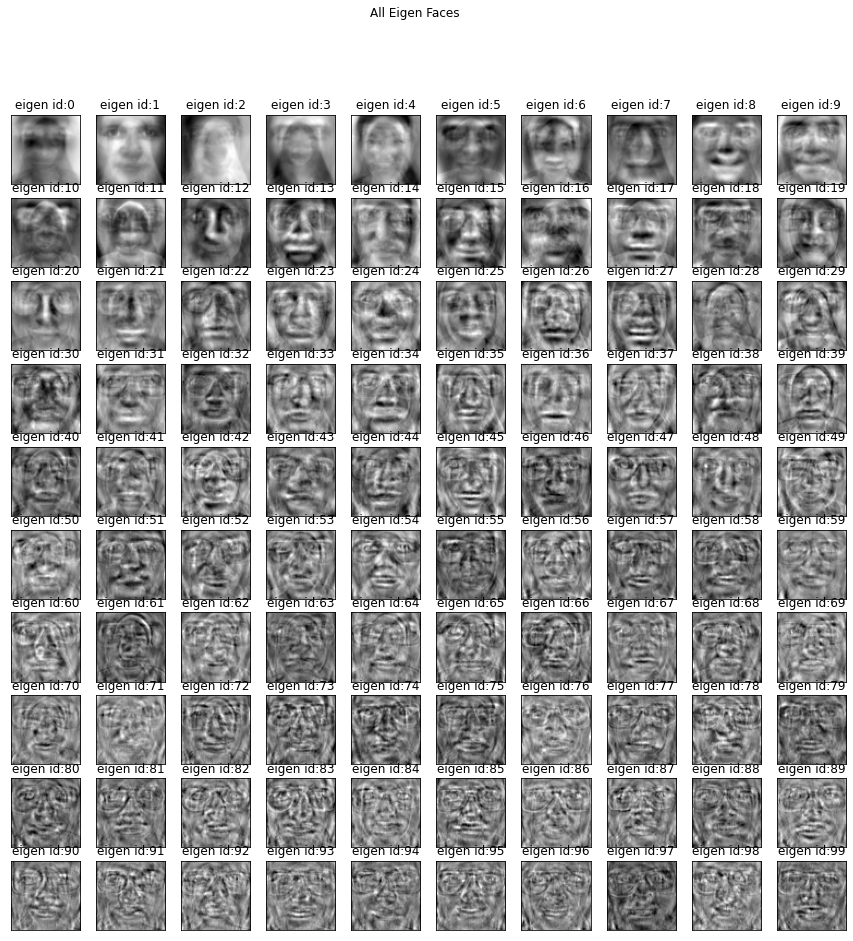

In [ ]:
number_of_eigenfaces=len(pca.components_) # quantities of components & explained variance determines the no of eigenfaces created
eigen_faces=pca.components_.reshape((number_of_eigenfaces, data.shape[1], data.shape[2]))

rows=10
cols=10
rows=int(number_of_eigenfaces/cols)
fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
axarr=axarr.flatten()
for i in range(number_of_eigenfaces):
    axarr[i].imshow(eigen_faces[i],cmap="gray")
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title("eigen id:{}".format(i))
plt.suptitle("All Eigen Faces".format(10*"=", 10*"="))

#####Shows the most prominent deviations from the mean in our dataset.

##Classification Results

In [ ]:
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

###1. Linear Discriminant Analysis

image.png

========== LINEAR DISCRIMINANT ANALYSIS CLASSIFICATION REPORT ==========
Accuracy score without PCA    :0.97
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      0.67      0.80         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00   

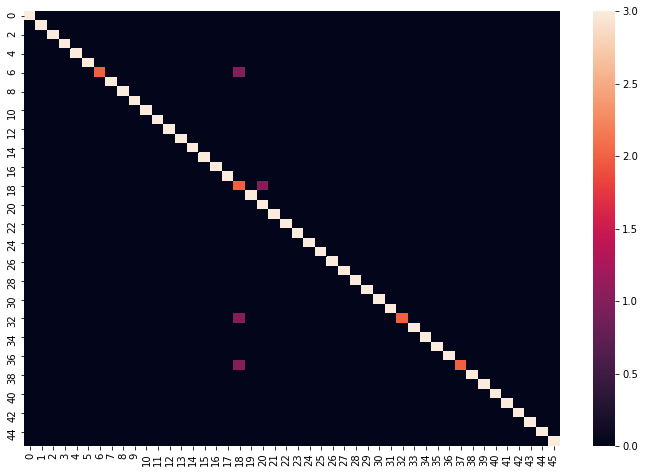

In [ ]:
clf=LinearDiscriminantAnalysis() # appearance-based technique used for the dimensionality reduction

clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print(10*"=","Linear Discriminant Analysis Classification Report".upper(),10*"=")
print("Accuracy score without PCA    :{:0.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))
print()
plt.figure(1, figsize=(12,8))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred))

#####The accuracy of Linear Discriminant Analysis is 97% without PCA.

###2. Logistic Regression

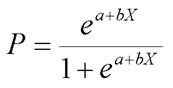

========== LOGISTIC REGRESSION CLASSIFICATION REPORT ==========
Accuracy score without PCA    :0.94
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      0.67      0.80         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       0.67      0.67  

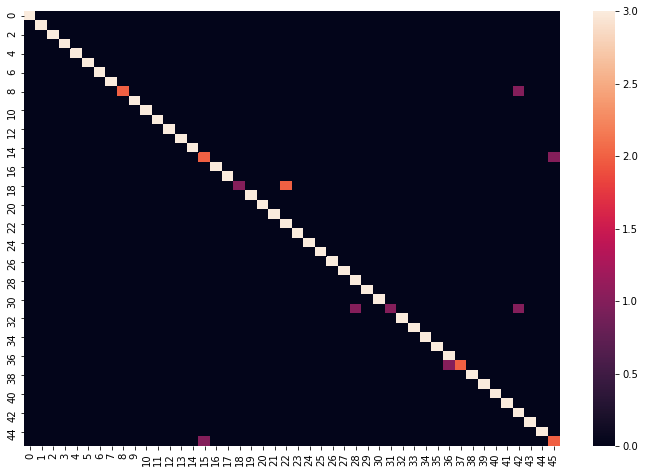

In [ ]:
clf=LogisticRegression()

clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print(10*"=","Logistic Regression Classification Report".upper(),10*"=")
print("Accuracy score without PCA    :{:0.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))
print()
plt.figure(1, figsize=(12,8))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred))

In [ ]:
  # plot learning curves
  plt.title('Training and validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.plot(sequential_model_train.history['accuracy'], label='Training accuracy')
  plt.plot(sequential_model_train.history['val_accuracy'], label='Validation accuracy')
  plt.legend()
  plt.show()

  plt.title('Training and validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.plot(sequential_model_train.history['loss'], label='Training loss')
  plt.plot(sequential_model_train.history['val_loss'], label='Validation loss')
  plt.legend()
  plt.show()

#####The accuracy of Logistic Regression is 94% without PCA.

###3. Gaussian Naive Bayes

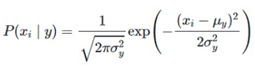

========== GAUSSIAN NB CLASSIFICATION REPORT ==========
Accuracy score without PCA    :0.88
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       0.60      1.00      0.75         3
           3       1.00      1.00      1.00         3
           4       1.00      0.33      0.50         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       0.50      0.33      0.40         3
           9       0.50      1.00      0.67         3
          10       1.00      0.33      0.50         3
          11       0.75      1.00      0.86         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      0.67      0.80         3
          15       1.00      0.67      0.80

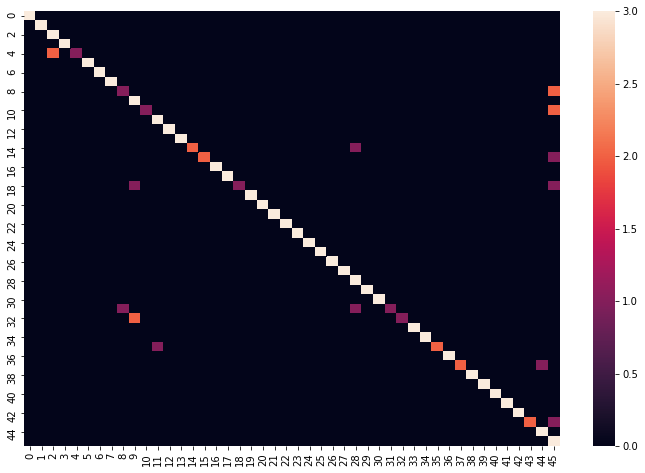

In [ ]:
clf=GaussianNB()

clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print(10*"=","Gaussian NB Classification Report".upper(),10*"=")
print("Accuracy score without PCA    :{:0.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))
print()
plt.figure(1, figsize=(12,8))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred))

#####The accuracy of Gaussian NB is 88% without PCA

###4. K-Nearest Neigbors 

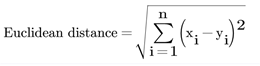

========== K NEIGHBORS CLASSIFIER CLASSIFICATION REPORT ==========
Accuracy score without PCA    :0.86
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       0.33      0.33      0.33         3
           7       1.00      1.00      1.00         3
           8       0.50      0.67      0.57         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       0.60      1.00      0.75         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       0.75      1.00      0.86         3
          15       1.00      0.6

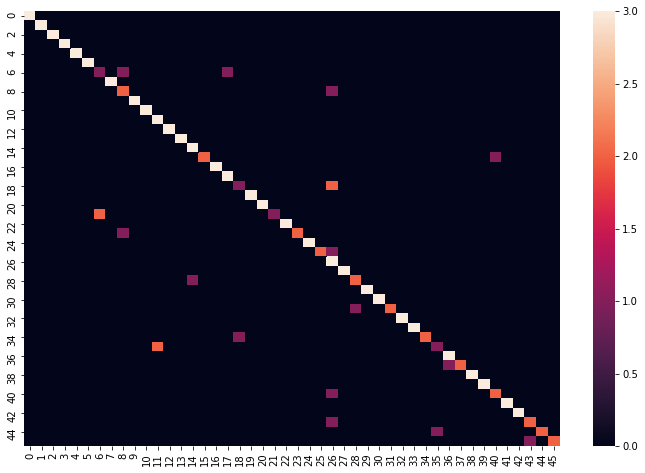

In [ ]:
clf=KNeighborsClassifier(n_neighbors=5) # choosing the default number of neighbors

clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print(10*"=","K Neighbors Classifier Classification Report".upper(),10*"=")
print("Accuracy score without PCA    :{:0.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))
print()
plt.figure(1, figsize=(12,8))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred))

#####The accuracy of K-Nearest Neighbors is 86% without PCA

###5. Decision Tree

========== DECISION TREE CLASSIFIER CLASSIFICATION REPORT ==========
Accuracy score without PCA    :0.62
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.75      1.00      0.86         3
           2       0.33      0.67      0.44         3
           3       1.00      0.67      0.80         3
           4       0.50      0.33      0.40         3
           5       1.00      1.00      1.00         3
           6       0.29      0.67      0.40         3
           7       1.00      0.33      0.50         3
           8       0.33      0.67      0.44         3
           9       0.25      0.33      0.29         3
          10       0.00      0.00      0.00         3
          11       1.00      0.33      0.50         3
          12       0.50      0.33      0.40         3
          13       0.67      0.67      0.67         3
          14       0.50      0.33      0.40         3
          15       0.00      0

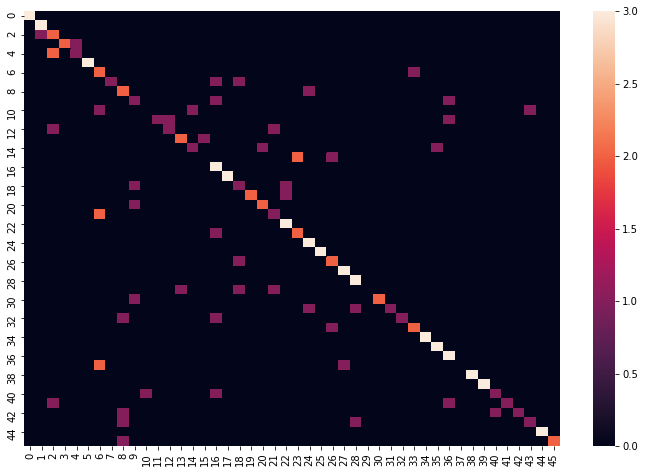

In [ ]:
clf=DecisionTreeClassifier()

clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print(10*"=","Decision Tree Classifier Classification Report".upper(),10*"=")
print("Accuracy score without PCA    :{:0.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))
print()
plt.figure(1, figsize=(12,8))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred))

#####The accuracy of Decision Tree classifier is 62% without PCA

###6. Support Vector Classification

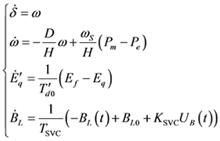

========== SUPPORT VECTOR MACHINE CLASSIFICATION REPORT ==========
Accuracy score without PCA    :0.93
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       0.67      0.67      0.67         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      0.67      0.80         3
          11       0.75      1.00      0.86         3
          12       1.00      0.33      0.50         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      0.6

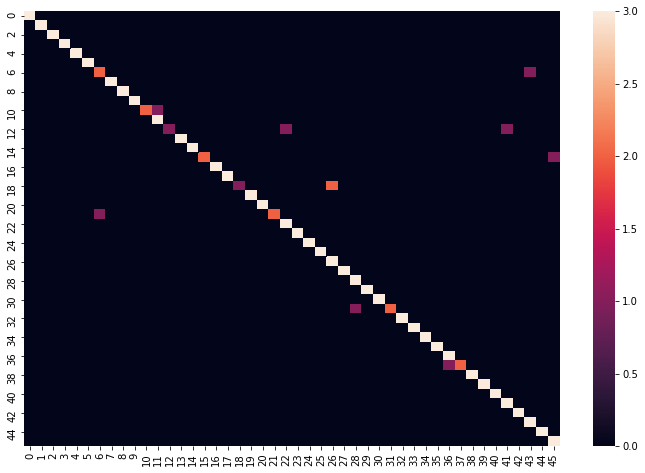

In [ ]:
clf=SVC()

clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print(10*"=","Support Vector Machine Classification Report".upper(),10*"=")
print("Accuracy score without PCA    :{:0.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))
print()
plt.figure(1, figsize=(12,8))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred))

#####The accuracy of SVC is 93% without PCA

###Obtaining accuracy results from machine learning model

In [ ]:
models=[] #Comparison of algorithm with and without PCA
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("KNN",KNeighborsClassifier(n_neighbors=5)))
models.append(("DT",DecisionTreeClassifier()))
models.append(("SVC",SVC()))


for name, model in models:
    
    clf=model
    clfPCA=model

    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)

    print(10*"=","{} Result".format(name).upper(),10*"=")
    print("Accuracy score with PCA    :{:0.2f}".format(metrics.accuracy_score(y_test, y_pred)))

    clfPCA.fit(X_train_pca, y_train)
    y_pred=clfPCA.predict(X_test_pca)

    print("Accuracy score without PCA :{:0.2f}".format(metrics.accuracy_score(y_test, y_pred)))
    print()
    print()

========== LDA RESULT ==========
Accuracy score with PCA    :0.97
Accuracy score without PCA :0.98


========== LR RESULT ==========
Accuracy score with PCA    :0.94
Accuracy score without PCA :0.94


========== NB RESULT ==========
Accuracy score with PCA    :0.88
Accuracy score without PCA :0.86


========== KNN RESULT ==========
Accuracy score with PCA    :0.86
Accuracy score without PCA :0.75


========== DT RESULT ==========
Accuracy score with PCA    :0.64
Accuracy score without PCA :0.58


========== SVM RESULT ==========
Accuracy score with PCA    :0.93
Accuracy score without PCA :0.96




> Linear Discriminant Analysis model appear to have the best results, based on the above findings.

### Significant Variables


*   Linear Discriminant Analysis - solver, n_components
*   Logictics Regression - C, Penalty
*   Gaussian Naive Bayes - priors, var_smoothing
*   K-Nearest Neighbors - X, n_neighbors
*   Decision Tree - criterion, splitter, max_depth
*   Support Vector Classification - C, kernel
*   Convolutional Neural Network - Batch Size, Kernel Size, Learning Rate



# **Part B**

###Models Evaluation

###Cross Validation Score

In [ ]:
pca=PCA(n_components=n_components, whiten=True)
pca.fit(X)
X_pca=pca.transform(X)

for i in range(2,11):
  print("K = ", i)
  for name, model in models:
      kfold=KFold(n_splits=i, shuffle=True, random_state=0) 
      cv_scoresPCA=cross_val_score(model, X_pca, target, cv=kfold)

      print(20*"=","{} Result".format(name).upper(),20*"=")
      print("Mean cross validations score with PCA    :{:.2f}".format(cv_scoresPCA.mean()))

      cv_scores=cross_val_score(model, X, target, cv=kfold)
      print("Mean cross validations score without PCA :{:.2f}".format(cv_scores.mean()))
      print()
      print()

K =  2
==================== LDA RESULT ====================
Mean cross validations score with PCA    :0.93
Mean cross validations score without PCA :0.93


==================== LR RESULT ====================
Mean cross validations score with PCA    :0.87
Mean cross validations score without PCA :0.91


==================== NB RESULT ====================
Mean cross validations score with PCA    :0.50
Mean cross validations score without PCA :0.56


==================== KNN RESULT ====================
Mean cross validations score with PCA    :0.63
Mean cross validations score without PCA :0.68


==================== DT RESULT ====================
Mean cross validations score with PCA    :0.38
Mean cross validations score without PCA :0.48


==================== SVM RESULT ====================
Mean cross validations score with PCA    :0.75
Mean cross validations score without PCA :0.74


K =  3
==================== LDA RESULT ====================
Mean cross validations score with PCA    :

> According to the cross validation scores,  Logistic Regression without PCA has the highest mean cross validation score

###Leave-One-Out Cross-Validation (LOOCV) 

In [ ]:
loo_cv=LeaveOneOut()
for name, model in models:
    
    clf=model
    cv_scores=cross_val_score(clf,
                         X_pca,
                         target,
                         cv=loo_cv)
    print(28*"=","{} Result".format(name).upper(),28*"=")
    print("Leave One Out cross-validation mean accuracy score with PCA    :{:.2f}".format(cv_scores.mean()))

    # cv_scoresPCA=cross_val_score(clf,
    #                      X,
    #                      target,
    #                      cv=loo_cv)
    # print("Leave One Out cross-validation mean accuracy score without PCA :{:.2f}".format(cv_scoresPCA.mean()))
    print()
    print()

============================ LDA RESULT ============================
Leave One Out cross-validation mean accuracy score with PCA    :0.98


============================ LR RESULT ============================
Leave One Out cross-validation mean accuracy score with PCA    :0.95


============================ NB RESULT ============================
Leave One Out cross-validation mean accuracy score with PCA    :0.87


============================ KNN RESULT ============================
Leave One Out cross-validation mean accuracy score with PCA    :0.83


============================ DT RESULT ============================
Leave One Out cross-validation mean accuracy score with PCA    :0.54


============================ SVM RESULT ============================
Leave One Out cross-validation mean accuracy score with PCA    :0.94




> According to LOOCV, Linear Discriminant Analysis has the highest mean accuracy score, 98%.

###Hyperparameter Tunning: GridSearcCV for LR, LDA & SVC






In [ ]:
params={'penalty':['l1', 'l2'],
                'C':np.logspace(0, 4, 10)
                }
gridSearchCV=GridSearchCV(LogisticRegression(), params, cv=LeaveOneOut())
gridSearchCV_Result = gridSearchCV.fit(X_train_pca, y_train)

print("Linear Regression score after grid search:{:.2f}".format(gridSearchCV_Result.best_score_))
print("Config: ", gridSearchCV_Result.best_params_)
print("LR after tuning: ",gridSearchCV_Result.best_estimator_)

Linear Regression score after grid search:0.91
Config:  {'C': 59.94842503189409, 'penalty': 'l2'}
LR after tuning:  LogisticRegression(C=59.94842503189409, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
lda_grid = dict()
lda_grid['solver'] = ['svd','lsqr','eigen']

gridSearchCV2=GridSearchCV(LinearDiscriminantAnalysis(), lda_grid, cv=LeaveOneOut())
gridSearchCV2_Result = gridSearchCV2.fit(X_train_pca, y_train)

print("Linear Discriminant Analysis score after grid search:{:.2f}".format(gridSearchCV2_Result.best_score_))
print("Config: ", gridSearchCV2_Result.best_params_)
print("LDA after tuning: ",gridSearchCV2_Result.best_estimator_)

Linear Discriminant Analysis score after grid search:0.97
Config:  {'solver': 'svd'}
LDA after tuning:  LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)


In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

gridSearchCV3 = GridSearchCV(SVC(), param_grid, refit = True,  cv=LeaveOneOut())
gridSearchCV3 = gridSearchCV3.fit(X_train_pca, y_train)
print("SVM score after grid search:{:.2f}".format(gridSearchCV3.best_score_))
print("Config: ",gridSearchCV3.best_params_)
print("SVM after tuning: ",gridSearchCV3.best_estimator_)

SVM score after grid search:0.92
Config:  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVM after tuning:  SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### Convolutional Neural Network (CNN)

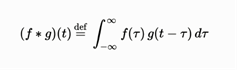

#### Preparation

In [ ]:
import tensorflow as tf
from tensorflow.keras import optimizers

# Constant variables
num_classes = len(np.unique(target))

# Declare Manipulative variables
batch_size = 4 # default = 4
epochs = 15 # default = 15
kSize = [1,3,5,7] # default = 3
 
opt_rmsprop = tf.keras.optimizers.RMSprop(lr=0.001, decay=1e-6)
opt_rmsprop2 = tf.keras.optimizers.RMSprop(lr=0.01, decay=1e-6)
opt_rmsprop3 = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
opt_adam = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

# data processing
X_trainCNN = X_train.reshape(-1, 64,64, 1)
X_testCNN = X_test.reshape(-1, 64,64, 1)
print(X_trainCNN.shape, X_testCNN.shape)

# data is in an int8 format
# before feeding it into the network, converting its type to float32
# rescaling the pixel values in range 0 - 1 inclusive
X_trainCNN = X_trainCNN.astype('float32')
X_testCNN = X_testCNN.astype('float32')
X_trainCNN = X_trainCNN / 255.
X_testCNN = X_testCNN / 255.

# Changing the labels from categorical to one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# train-test split
X_trainCNN, valid_X, train_label, valid_label = train_test_split(X_trainCNN, y_train_one_hot, test_size=0.3, random_state=13)
print(X_trainCNN.shape, valid_X.shape, train_label.shape, valid_label.shape)

(322, 64, 64, 1) (138, 64, 64, 1)
(225, 64, 64, 1) (97, 64, 64, 1) (225, 46) (97, 46)


#### Create functions

In [ ]:
# EarlyStopping to prevent the overfitting and stop trainning if no progress on the validation set in 3 epochs
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min',verbose=1, patience = 3)

In [ ]:
# class StopOnPoint(tf.keras.callbacks.Callback):
#     def __init__(self, point):
#         super(StopOnPoint, self).__init__()
#         self.point = point

#     def on_epoch_end(self, epoch, logs=None): 
#         accuracy = logs["accuracy"]
#         if accuracy >= self.point:
#             self.model.stop_training = True

In [ ]:
def model_define_compile(opt, num_classes):
  # define model
  sequential_model = Sequential()
  sequential_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(64,64,1),padding='same'))
  sequential_model.add(LeakyReLU(alpha=0.1))
  sequential_model.add(MaxPooling2D((2, 2),padding='same'))
  sequential_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
  sequential_model.add(LeakyReLU(alpha=0.1))
  sequential_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  sequential_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
  sequential_model.add(LeakyReLU(alpha=0.1))                  
  sequential_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  sequential_model.add(Flatten())
  sequential_model.add(Dense(128, activation='linear'))
  sequential_model.add(LeakyReLU(alpha=0.1))                  
  sequential_model.add(Dense(num_classes, activation='softmax'))

  # compile the model
  sequential_model.compile(loss='categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
  print('Optimizer:', opt)
  sequential_model.summary()
  return sequential_model

In [ ]:
# Add dropout layer
def model_define_compile2(opt, num_classes):
  # define model
  sequential_model = Sequential()
  sequential_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(64,64,1),padding='same'))
  sequential_model.add(LeakyReLU(alpha=0.1))
  sequential_model.add(MaxPooling2D((2, 2),padding='same'))
  sequential_model.add(Dropout(0.5))
  sequential_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
  sequential_model.add(LeakyReLU(alpha=0.1))
  sequential_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  sequential_model.add(Dropout(0.5))
  sequential_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
  sequential_model.add(LeakyReLU(alpha=0.1))                  
  sequential_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  sequential_model.add(Dropout(0.5))
  sequential_model.add(Flatten())
  sequential_model.add(Dense(128, activation='linear'))
  sequential_model.add(LeakyReLU(alpha=0.1))                  
  sequential_model.add(Dense(num_classes, activation='softmax'))

  # compile the model
  sequential_model.compile(loss='categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
  print('Optimizer:', opt)
  sequential_model.summary()
  return sequential_model

In [ ]:
# model to test different kernel size
def model_define_compile3(opt, kSize):
  # define model
  sequential_model = Sequential()
  sequential_model.add(Conv2D(32, kernel_size=(kSize, kSize),activation='linear',input_shape=(64,64,1),padding='same'))
  sequential_model.add(LeakyReLU(alpha=0.1))
  sequential_model.add(MaxPooling2D((2, 2),padding='same'))
  sequential_model.add(Conv2D(64, (kSize, kSize), activation='linear',padding='same'))
  sequential_model.add(LeakyReLU(alpha=0.1))
  sequential_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  sequential_model.add(Conv2D(128, (kSize, kSize), activation='linear',padding='same'))
  sequential_model.add(LeakyReLU(alpha=0.1))                  
  sequential_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  sequential_model.add(Flatten())
  sequential_model.add(Dense(128, activation='linear'))
  sequential_model.add(LeakyReLU(alpha=0.1))                  
  sequential_model.add(Dense(num_classes, activation='softmax'))

  # compile the model
  sequential_model.compile(loss='categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
  print('Optimizer:', opt)
  sequential_model.summary()
  return sequential_model

In [ ]:
# add 1 Conv2D, MaxPooling2D, Leak
def model_define_compile4(opt):
  # define model
  sequential_model = Sequential()
  sequential_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(64,64,1),padding='same'))
  sequential_model.add(LeakyReLU(alpha=0.1))
  sequential_model.add(MaxPooling2D((2, 2),padding='same'))
  sequential_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
  sequential_model.add(LeakyReLU(alpha=0.1))
  sequential_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  sequential_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
  sequential_model.add(LeakyReLU(alpha=0.1))                  
  sequential_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  sequential_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
  sequential_model.add(LeakyReLU(alpha=0.1))
  sequential_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  sequential_model.add(Flatten())
  sequential_model.add(Dense(64, activation='linear'))
  sequential_model.add(LeakyReLU(alpha=0.1))                  
  sequential_model.add(Dense(num_classes, activation='softmax'))

  # compile the model
  sequential_model.compile(loss='categorical_crossentropy', optimizer=opt ,metrics=['accuracy'])
  print('Optimizer:', opt)
  sequential_model.summary()
  return sequential_model

In [ ]:
def fit_model(sequential_model): 
  # fit the model
  sequential_model_train = sequential_model.fit(X_trainCNN, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label), callbacks = [es])
  return sequential_model_train

In [ ]:
def fit_model2(sequential_model, bSize, epo): 
  # fit the model
  sequential_model_train = sequential_model.fit(X_trainCNN, train_label, batch_size=bSize,epochs=epo,verbose=1,validation_data=(valid_X, valid_label), callbacks = [es])
  return sequential_model_train

In [ ]:
## Use callback to stop epoch when accuracy > 0.98
 ## sequential_model_train = sequential_model.fit(X_trainCNN, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label), callbacks = [StopOnPoint(0.98)])

In [ ]:
def test_model(sequential_model):
  # test model
  test_sequential_model = sequential_model.evaluate(X_testCNN, y_test_one_hot, verbose=1)
  print('Test loss:', test_sequential_model[0])
  print('Test accuracy:', test_sequential_model[1])

In [ ]:
def plot_learning_curves(sequential_model_train):
  # plot learning curves
  plt.title('Training and validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.plot(sequential_model_train.history['accuracy'], label='Training accuracy')
  plt.plot(sequential_model_train.history['val_accuracy'], label='Validation accuracy')
  plt.legend()
  plt.show()

  plt.title('Training and validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.plot(sequential_model_train.history['loss'], label='Training loss')
  plt.plot(sequential_model_train.history['val_loss'], label='Validation loss')
  plt.legend()
  plt.show()

In [ ]:
def predict_classes(sequential_model, y_test, X_testCNN):
  # predict labels
  predicted_classes = sequential_model.predict(X_testCNN)
  predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

  y_test_flatten = y_test.flatten()
  print(predicted_classes.shape, y_test_flatten.shape)
  return predicted_classes, y_test_flatten

In [ ]:
def correct_labels(predicted_classes, y_test_flatten, X_testCNN):
  correct = (np.where(predicted_classes==y_test_flatten)[0])
  print("Found %d correct labels" % len(correct))
  for i, correct in enumerate(correct[:9]):
    plt.subplot(5,5,i+1)
    plt.imshow(X_testCNN[correct].reshape(64,64), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    plt.tight_layout()

In [ ]:
def incorrect_labels(predicted_classes, y_test_flatten, X_testCNN):
  incorrect = np.where(predicted_classes!=y_test_flatten)[0]
  print("Found %d incorrect labels" % len(incorrect))

  for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[incorrect].reshape(64,64), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    plt.tight_layout()

In [ ]:
def produce_classification_report(num_classes, y_test, predicted_classes):
  # Classification Report
  print(10*"=","CNN Classification Report".upper(),10*"=")
  target_names = ["Class {}".format(i) for i in range(num_classes)]
  print(classification_report(y_test, predicted_classes, target_names=target_names))
  print()
  plt.figure(1, figsize=(12,8))
  sns.heatmap(metrics.confusion_matrix(y_test, predicted_classes))

#### Model 1 with Adam Optimizer

In [ ]:
m1_sequential_model = model_define_compile(opt_adam, num_classes)

Optimizer: <keras.optimizer_v2.adam.Adam object at 0x7f433d6955d0>
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
leaky_re_lu_103 (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_104 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 16, 16, 64)        0         
____________________________________________________

In [ ]:
m1_sequential_model_train = fit_model(m1_sequential_model)

Epoch 1/15
57/57 [==============================] - 3s 58ms/step - loss: 3.7791 - accuracy: 0.0533 - val_loss: 3.8252 - val_accuracy: 0.0515
Epoch 2/15
57/57 [==============================] - 3s 59ms/step - loss: 3.5624 - accuracy: 0.0978 - val_loss: 3.3984 - val_accuracy: 0.1134
Epoch 3/15
57/57 [==============================] - 3s 59ms/step - loss: 3.3220 - accuracy: 0.1333 - val_loss: 3.4203 - val_accuracy: 0.1546
Epoch 4/15
57/57 [==============================] - 3s 58ms/step - loss: 2.9117 - accuracy: 0.2489 - val_loss: 2.9703 - val_accuracy: 0.3299
Epoch 5/15
57/57 [==============================] - 3s 59ms/step - loss: 2.0144 - accuracy: 0.5156 - val_loss: 2.4194 - val_accuracy: 0.4124
Epoch 6/15
57/57 [==============================] - 3s 59ms/step - loss: 1.1860 - accuracy: 0.6667 - val_loss: 1.7514 - val_accuracy: 0.5876
Epoch 7/15
57/57 [==============================] - 3s 55ms/step - loss: 0.6526 - accuracy: 0.8178 - val_loss: 1.5924 - val_accuracy: 0.7010
Epoch 8/15
57

In [ ]:
test_model(m1_sequential_model)

5/5 [==============================] - 0s 69ms/step - loss: 0.5173 - accuracy: 0.8986
Test loss: 0.5172661542892456
Test accuracy: 0.8985507488250732


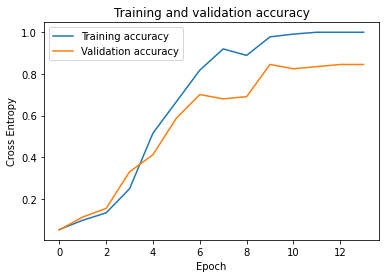

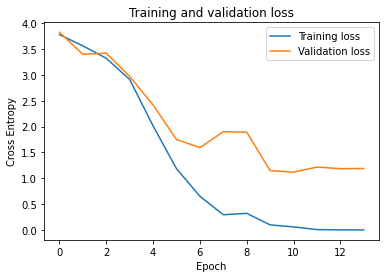

In [ ]:
plot_learning_curves(m1_sequential_model_train)

In [ ]:
m1_predicted_classes, m1_y_test_flatten = predict_classes(m1_sequential_model, y_test, X_testCNN)

(138,) (138,)


Found 124 correct labels


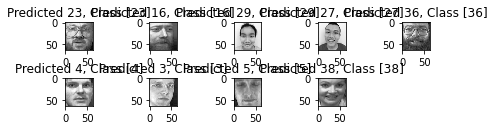

In [ ]:
correct_labels(m1_predicted_classes, m1_y_test_flatten, X_trainCNN)

Found 14 incorrect labels


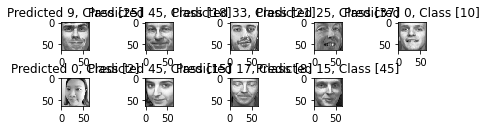

In [ ]:
incorrect_labels(m1_predicted_classes, m1_y_test_flatten, X_trainCNN)

========== CNN CLASSIFICATION REPORT ==========
              precision    recall  f1-score   support

     Class 0       0.50      1.00      0.67         3
     Class 1       1.00      1.00      1.00         3
     Class 2       1.00      0.67      0.80         3
     Class 3       1.00      1.00      1.00         3
     Class 4       1.00      1.00      1.00         3
     Class 5       1.00      1.00      1.00         3
     Class 6       1.00      1.00      1.00         3
     Class 7       1.00      1.00      1.00         3
     Class 8       1.00      0.67      0.80         3
     Class 9       0.75      1.00      0.86         3
    Class 10       1.00      0.33      0.50         3
    Class 11       1.00      0.67      0.80         3
    Class 12       1.00      0.67      0.80         3
    Class 13       0.75      1.00      0.86         3
    Class 14       1.00      1.00      1.00         3
    Class 15       0.50      0.33      0.40         3
    Class 16       1.00      1.00

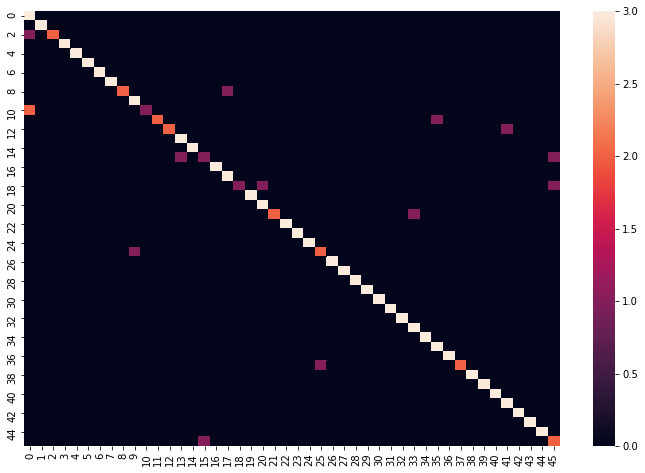

In [ ]:
produce_classification_report(num_classes, y_test, m1_predicted_classes)

#### Model 2 with RMSprop optimizer 


In [ ]:
m2_sequential_model = model_define_compile(opt_rmsprop, num_classes)

Optimizer: <keras.optimizer_v2.rmsprop.RMSprop object at 0x7f433d695590>
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
leaky_re_lu_107 (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_108 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 16, 16, 64)        0         
______________________________________________

In [ ]:
m2_sequential_model_train = fit_model(m2_sequential_model)

Epoch 1/15
57/57 [==============================] - 5s 66ms/step - loss: 3.9030 - accuracy: 0.0267 - val_loss: 3.8686 - val_accuracy: 0.0103
Epoch 2/15
57/57 [==============================] - 4s 63ms/step - loss: 3.7203 - accuracy: 0.0756 - val_loss: 3.6162 - val_accuracy: 0.0619
Epoch 3/15
57/57 [==============================] - 4s 63ms/step - loss: 3.2264 - accuracy: 0.2622 - val_loss: 3.4903 - val_accuracy: 0.2062
Epoch 4/15
57/57 [==============================] - 3s 61ms/step - loss: 1.9145 - accuracy: 0.5022 - val_loss: 2.3010 - val_accuracy: 0.5052
Epoch 5/15
57/57 [==============================] - 3s 61ms/step - loss: 0.9480 - accuracy: 0.7422 - val_loss: 1.6837 - val_accuracy: 0.6598
Epoch 6/15
57/57 [==============================] - 4s 62ms/step - loss: 0.4794 - accuracy: 0.8889 - val_loss: 2.4102 - val_accuracy: 0.6495
Epoch 7/15
57/57 [==============================] - 4s 62ms/step - loss: 0.2688 - accuracy: 0.9156 - val_loss: 0.6637 - val_accuracy: 0.8247
Epoch 8/15
57

In [ ]:
test_model(m2_sequential_model)

5/5 [==============================] - 0s 69ms/step - loss: 0.3340 - accuracy: 0.9275
Test loss: 0.3340434432029724
Test accuracy: 0.9275362491607666


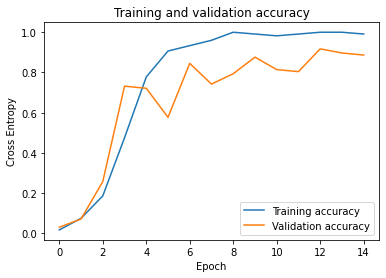

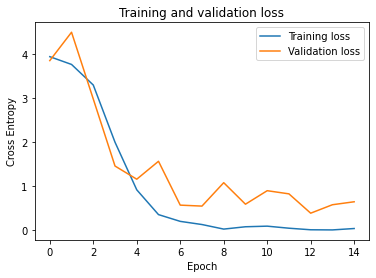

In [ ]:
plot_learning_curves(m2_sequential_model_train)

In [ ]:
m2_predicted_classes, m2_y_test_flatten = predict_classes(m2_sequential_model, y_test, X_testCNN)

(138,) (138,)


Found 128 correct labels


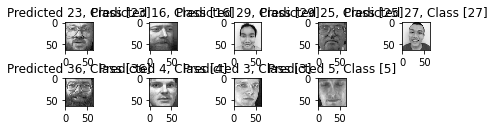

In [ ]:
correct_labels(m2_predicted_classes, m2_y_test_flatten, X_trainCNN)

Found 10 incorrect labels


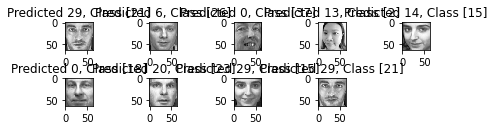

In [ ]:
incorrect_labels(m2_predicted_classes, m2_y_test_flatten, X_trainCNN)

========== CNN CLASSIFICATION REPORT ==========
              precision    recall  f1-score   support

     Class 0       0.60      1.00      0.75         3
     Class 1       1.00      1.00      1.00         3
     Class 2       1.00      0.67      0.80         3
     Class 3       1.00      1.00      1.00         3
     Class 4       1.00      1.00      1.00         3
     Class 5       1.00      1.00      1.00         3
     Class 6       0.75      1.00      0.86         3
     Class 7       1.00      1.00      1.00         3
     Class 8       1.00      1.00      1.00         3
     Class 9       1.00      1.00      1.00         3
    Class 10       1.00      1.00      1.00         3
    Class 11       1.00      1.00      1.00         3
    Class 12       1.00      1.00      1.00         3
    Class 13       0.75      1.00      0.86         3
    Class 14       0.75      1.00      0.86         3
    Class 15       0.00      0.00      0.00         3
    Class 16       1.00      1.00

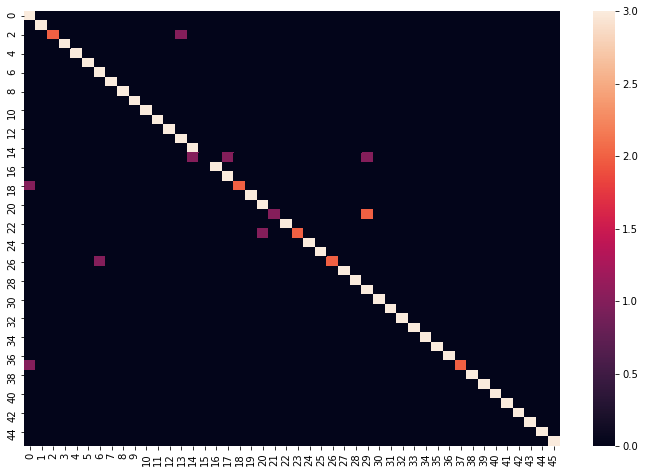

In [ ]:
produce_classification_report(num_classes, y_test, m2_predicted_classes)

##### Conclusion from Model 1 & 2 

> After Model 1 & 2, RMSprop optimizer perform slighly better than Adam optimizer when both with learning rate 0.01.

##### Model 2B with 0.01 learning rate


In [ ]:
m2b_sequential_model = model_define_compile(opt_rmsprop2, num_classes)

Optimizer: <keras.optimizer_v2.rmsprop.RMSprop object at 0x7fc3a171e3d0>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________

In [ ]:
m2b_sequential_model_train = fit_model(m2b_sequential_model)

Epoch 1/15
57/57 [==============================] - 1s 10ms/step - loss: 9.7414 - accuracy: 0.0978 - val_loss: 552.2257 - val_accuracy: 0.0309
Epoch 2/15
57/57 [==============================] - 1s 11ms/step - loss: 26.3459 - accuracy: 0.0978 - val_loss: 14.7748 - val_accuracy: 0.1340
Epoch 3/15
57/57 [==============================] - 1s 10ms/step - loss: 22.2121 - accuracy: 0.1067 - val_loss: 11.0477 - val_accuracy: 0.1134
Epoch 4/15
57/57 [==============================] - 1s 11ms/step - loss: 8.6803 - accuracy: 0.1600 - val_loss: 8.6335 - val_accuracy: 0.1340
Epoch 5/15
57/57 [==============================] - 1s 10ms/step - loss: 69.5219 - accuracy: 0.0844 - val_loss: 13.9046 - val_accuracy: 0.1546
Epoch 6/15
57/57 [==============================] - 1s 11ms/step - loss: 18.9806 - accuracy: 0.2044 - val_loss: 12.0637 - val_accuracy: 0.1649
Epoch 7/15
57/57 [==============================] - 1s 10ms/step - loss: 17.6914 - accuracy: 0.2044 - val_loss: 14.6337 - val_accuracy: 0.1443
E

In [ ]:
test_model(m2b_sequential_model)

5/5 [==============================] - 0s 24ms/step - loss: 13.1648 - accuracy: 0.1812
Test loss: 13.164824485778809
Test accuracy: 0.18115942180156708


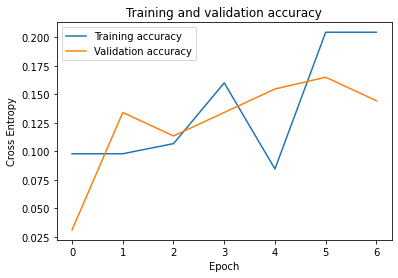

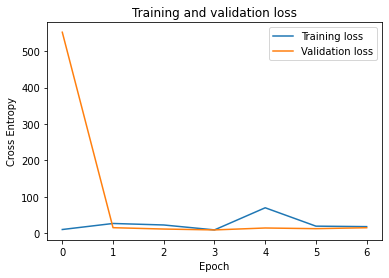

In [ ]:
plot_learning_curves(m2b_sequential_model_train)

In [ ]:
m2b_predicted_classes, m2b_y_test_flatten = predict_classes(m2b_sequential_model, y_test, X_testCNN)

(138,) (138,)


========== CNN CLASSIFICATION REPORT ==========
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         3
     Class 1       0.75      1.00      0.86         3
     Class 2       1.00      0.67      0.80         3
     Class 3       1.00      1.00      1.00         3
     Class 4       1.00      1.00      1.00         3
     Class 5       1.00      1.00      1.00         3
     Class 6       0.00      0.00      0.00         3
     Class 7       0.00      0.00      0.00         3
     Class 8       0.00      0.00      0.00         3
     Class 9       0.00      0.00      0.00         3
    Class 10       0.00      0.00      0.00         3
    Class 11       0.00      0.00      0.00         3
    Class 12       0.00      0.00      0.00         3
    Class 13       0.00      0.00      0.00         3
    Class 14       0.00      0.00      0.00         3
    Class 15       0.00      0.00      0.00         3
    Class 16       0.00      0.00

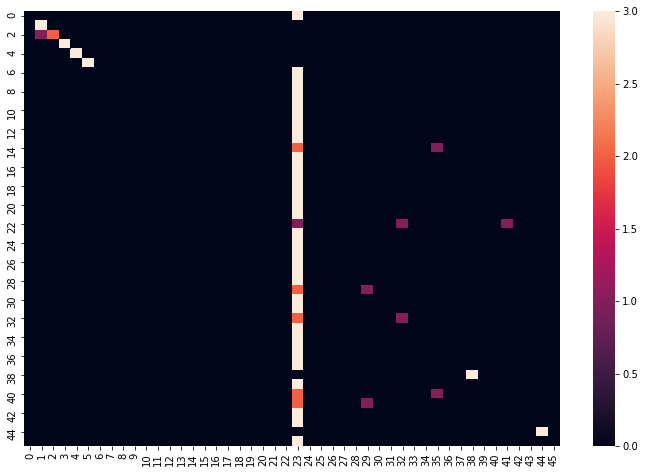

In [ ]:
produce_classification_report(num_classes, y_test, m2b_predicted_classes)

##### Model 2C with 0.0001 learning rate

In [ ]:
m2c_sequential_model = model_define_compile(opt_rmsprop3, num_classes)
m2c_sequential_model_train = fit_model(m2c_sequential_model)
test_model(m2c_sequential_model)

Optimizer: <keras.optimizer_v2.rmsprop.RMSprop object at 0x7f4340fad450>
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 16, 16, 64)        0         
______________________________________________

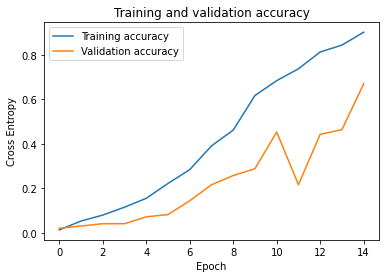

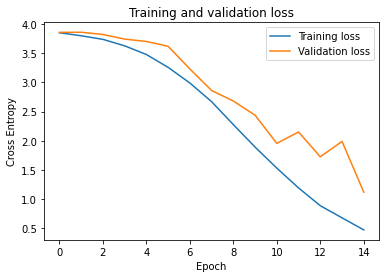

In [ ]:
plot_learning_curves(m2c_sequential_model_train)

In [ ]:
m2c_predicted_classes, m2c_y_test_flatten = predict_classes(m2c_sequential_model, y_test, X_testCNN)

(138,) (138,)


========== CNN CLASSIFICATION REPORT ==========
              precision    recall  f1-score   support

     Class 0       0.07      1.00      0.13         3
     Class 1       1.00      1.00      1.00         3
     Class 2       1.00      1.00      1.00         3
     Class 3       1.00      1.00      1.00         3
     Class 4       1.00      1.00      1.00         3
     Class 5       1.00      1.00      1.00         3
     Class 6       0.00      0.00      0.00         3
     Class 7       1.00      1.00      1.00         3
     Class 8       1.00      0.33      0.50         3
     Class 9       1.00      1.00      1.00         3
    Class 10       0.00      0.00      0.00         3
    Class 11       0.60      1.00      0.75         3
    Class 12       1.00      0.67      0.80         3
    Class 13       0.00      0.00      0.00         3
    Class 14       1.00      0.33      0.50         3
    Class 15       0.00      0.00      0.00         3
    Class 16       0.75      1.00

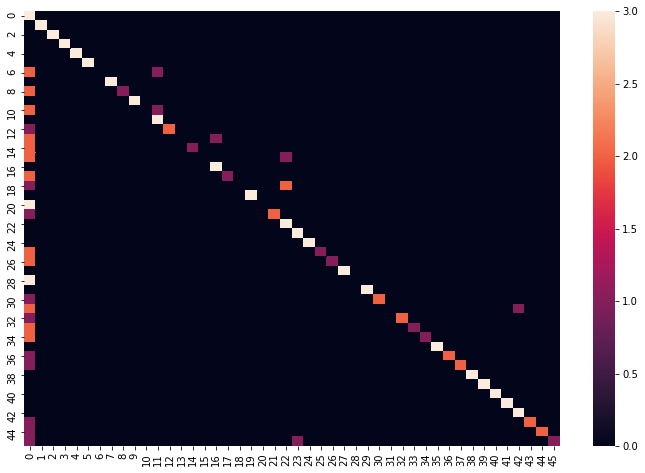

In [ ]:
produce_classification_report(num_classes, y_test, m2c_predicted_classes)

#### Conclusion from Model 1, 2, 2B & 2C in comparing different optimizer and learning rate
> When comparing different learning rate from 0.01 to 0.001 and 0.001, we found that the learning rate 0.001 has the best result. Hence, we will use the RMSprop optimizer with learning rate 0.01 for the rest of the CNN models.

#### Model 3 with RMSprop optimizer + Dropout


In [ ]:
m3_sequential_model = model_define_compile2(opt_rmsprop, num_classes)

Optimizer: <keras.optimizer_v2.rmsprop.RMSprop object at 0x7f433d695590>
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
leaky_re_lu_115 (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_116 (LeakyReLU)  (None, 32, 32, 64)        0         
______________________________________________

In [ ]:
m3_sequential_model_train = fit_model(m3_sequential_model)

Epoch 1/15
57/57 [==============================] - 5s 69ms/step - loss: 3.8816 - accuracy: 0.0133 - val_loss: 3.8381 - val_accuracy: 0.0000e+00
Epoch 2/15
57/57 [==============================] - 4s 64ms/step - loss: 3.8294 - accuracy: 0.0133 - val_loss: 3.9209 - val_accuracy: 0.0000e+00
Epoch 3/15
57/57 [==============================] - 4s 65ms/step - loss: 3.7629 - accuracy: 0.0622 - val_loss: 3.8253 - val_accuracy: 0.0206
Epoch 4/15
57/57 [==============================] - 4s 65ms/step - loss: 3.3663 - accuracy: 0.1644 - val_loss: 3.4536 - val_accuracy: 0.0928
Epoch 5/15
57/57 [==============================] - 4s 63ms/step - loss: 2.4826 - accuracy: 0.3600 - val_loss: 2.2857 - val_accuracy: 0.4124
Epoch 6/15
57/57 [==============================] - 4s 65ms/step - loss: 1.3112 - accuracy: 0.6533 - val_loss: 1.7356 - val_accuracy: 0.5670
Epoch 7/15
57/57 [==============================] - 4s 64ms/step - loss: 0.7149 - accuracy: 0.8044 - val_loss: 3.6735 - val_accuracy: 0.2784
Epoch

In [ ]:
test_model(m3_sequential_model)

5/5 [==============================] - 0s 71ms/step - loss: 0.3178 - accuracy: 0.9058
Test loss: 0.31781965494155884
Test accuracy: 0.9057971239089966


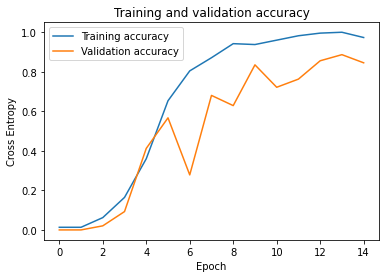

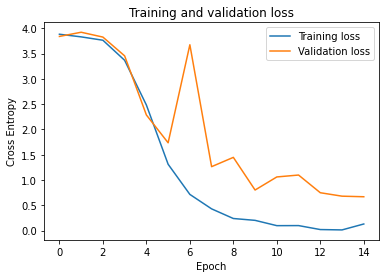

In [ ]:
plot_learning_curves(m3_sequential_model_train)

In [ ]:
m3_predicted_classes, m3_y_test_flatten = predict_classes(m3_sequential_model, y_test, X_testCNN)

(138,) (138,)


Found 125 correct labels


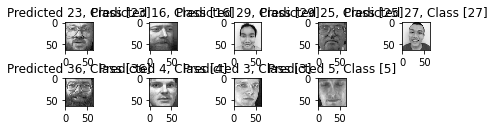

In [ ]:
correct_labels(m3_predicted_classes, m3_y_test_flatten, X_trainCNN)

Found 13 incorrect labels


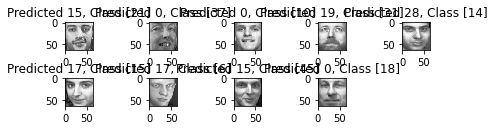

In [ ]:
incorrect_labels(m3_predicted_classes, m3_y_test_flatten, X_trainCNN)

========== CNN CLASSIFICATION REPORT ==========
              precision    recall  f1-score   support

     Class 0       0.50      1.00      0.67         3
     Class 1       1.00      1.00      1.00         3
     Class 2       1.00      1.00      1.00         3
     Class 3       1.00      1.00      1.00         3
     Class 4       1.00      1.00      1.00         3
     Class 5       1.00      1.00      1.00         3
     Class 6       1.00      0.67      0.80         3
     Class 7       1.00      1.00      1.00         3
     Class 8       0.75      1.00      0.86         3
     Class 9       1.00      1.00      1.00         3
    Class 10       1.00      0.33      0.50         3
    Class 11       1.00      1.00      1.00         3
    Class 12       1.00      1.00      1.00         3
    Class 13       1.00      1.00      1.00         3
    Class 14       1.00      0.67      0.80         3
    Class 15       0.00      0.00      0.00         3
    Class 16       1.00      1.00

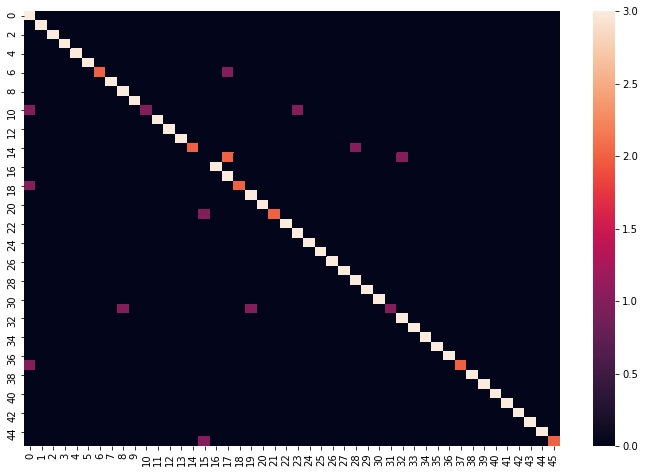

In [ ]:
produce_classification_report(num_classes, y_test, m3_predicted_classes)

#### Conclusion from Model 2 & 3 in comparing the use of dropout layer

> The test accuracy for both Model 2 and 3 are 0.93 and 0.91. As a result, adding the dropout layer does not considerably affect the performance of the model.

#### Model 4 with RMSprop optimizer but con2d kernel size 1x1

In [ ]:
m4_sequential_model = model_define_compile3(opt_rmsprop, 1)

Optimizer: <keras.optimizer_v2.rmsprop.RMSprop object at 0x7f433d695590>
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_128 (Conv2D)          (None, 64, 64, 32)        64        
_________________________________________________________________
leaky_re_lu_169 (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 32, 32, 64)        2112      
_________________________________________________________________
leaky_re_lu_170 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_129 (MaxPoolin (None, 16, 16, 64)        0         
______________________________________________

In [ ]:
m4_sequential_model_train = fit_model(m4_sequential_model)

Epoch 1/15
57/57 [==============================] - 3s 32ms/step - loss: 3.8832 - accuracy: 0.0178 - val_loss: 3.8845 - val_accuracy: 0.0103
Epoch 2/15
57/57 [==============================] - 2s 29ms/step - loss: 3.6312 - accuracy: 0.1156 - val_loss: 3.6045 - val_accuracy: 0.0515
Epoch 3/15
57/57 [==============================] - 2s 29ms/step - loss: 2.8904 - accuracy: 0.2667 - val_loss: 3.2541 - val_accuracy: 0.1753
Epoch 4/15
57/57 [==============================] - 2s 27ms/step - loss: 1.9309 - accuracy: 0.4711 - val_loss: 2.6504 - val_accuracy: 0.3299
Epoch 5/15
57/57 [==============================] - 2s 28ms/step - loss: 1.0979 - accuracy: 0.6978 - val_loss: 2.1384 - val_accuracy: 0.4021
Epoch 6/15
57/57 [==============================] - 2s 28ms/step - loss: 0.6537 - accuracy: 0.7956 - val_loss: 3.2050 - val_accuracy: 0.4845
Epoch 7/15
57/57 [==============================] - 2s 28ms/step - loss: 0.4011 - accuracy: 0.8800 - val_loss: 1.7500 - val_accuracy: 0.6186
Epoch 8/15
57

In [ ]:
test_model(m4_sequential_model)

5/5 [==============================] - 0s 28ms/step - loss: 0.9126 - accuracy: 0.7971
Test loss: 0.9126491546630859
Test accuracy: 0.7971014380455017


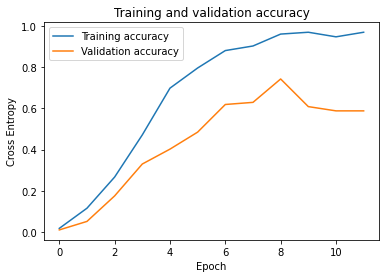

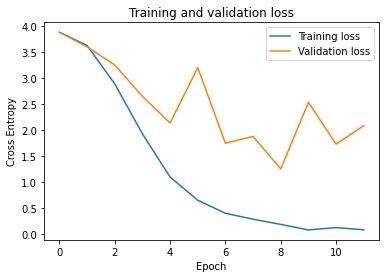

In [ ]:
plot_learning_curves(m4_sequential_model_train)

In [ ]:
m4_predicted_classes, m4_y_test_flatten = predict_classes(m4_sequential_model, y_test, X_testCNN)

(138,) (138,)


Found 108 correct labels


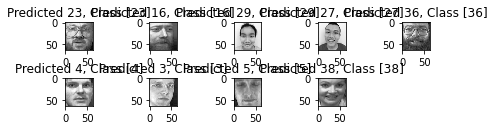

In [ ]:
correct_labels(m4_predicted_classes, m4_y_test_flatten, X_trainCNN)

Found 30 incorrect labels


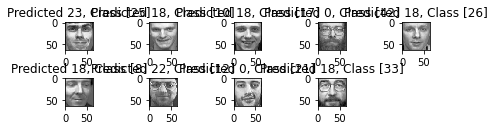

In [ ]:
incorrect_labels(m4_predicted_classes, m4_y_test_flatten, X_trainCNN)

========== CNN CLASSIFICATION REPORT ==========
              precision    recall  f1-score   support

     Class 0       0.33      1.00      0.50         3
     Class 1       1.00      1.00      1.00         3
     Class 2       1.00      0.67      0.80         3
     Class 3       1.00      1.00      1.00         3
     Class 4       1.00      1.00      1.00         3
     Class 5       1.00      1.00      1.00         3
     Class 6       1.00      0.33      0.50         3
     Class 7       1.00      1.00      1.00         3
     Class 8       0.00      0.00      0.00         3
     Class 9       1.00      0.67      0.80         3
    Class 10       0.00      0.00      0.00         3
    Class 11       1.00      0.67      0.80         3
    Class 12       1.00      0.33      0.50         3
    Class 13       0.75      1.00      0.86         3
    Class 14       1.00      0.67      0.80         3
    Class 15       1.00      0.33      0.50         3
    Class 16       1.00      1.00

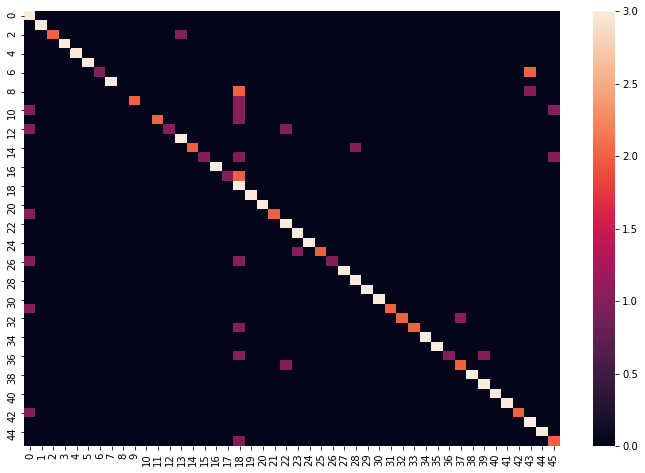

In [ ]:
produce_classification_report(num_classes, y_test, m4_predicted_classes)

#### Model 5 with RMSprop optimizer but con2d kernel size 7x7

In [ ]:
m5_sequential_model = model_define_compile3(opt_rmsprop, kSize[3])

Optimizer: <keras.optimizer_v2.rmsprop.RMSprop object at 0x7f433d695590>
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_131 (Conv2D)          (None, 64, 64, 32)        1600      
_________________________________________________________________
leaky_re_lu_173 (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_131 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_132 (Conv2D)          (None, 32, 32, 64)        100416    
_________________________________________________________________
leaky_re_lu_174 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_132 (MaxPoolin (None, 16, 16, 64)        0         
______________________________________________

In [ ]:
m5_sequential_model_train = fit_model(m5_sequential_model)

Epoch 1/15
57/57 [==============================] - 10s 170ms/step - loss: 5.0208 - accuracy: 0.0178 - val_loss: 3.8754 - val_accuracy: 0.0103
Epoch 2/15
57/57 [==============================] - 9s 166ms/step - loss: 3.9645 - accuracy: 0.0178 - val_loss: 3.9362 - val_accuracy: 0.0206
Epoch 3/15
57/57 [==============================] - 10s 168ms/step - loss: 4.0604 - accuracy: 0.0444 - val_loss: 3.8144 - val_accuracy: 0.0412
Epoch 4/15
57/57 [==============================] - 9s 167ms/step - loss: 3.8804 - accuracy: 0.0667 - val_loss: 3.5941 - val_accuracy: 0.0515
Epoch 5/15
57/57 [==============================] - 9s 166ms/step - loss: 3.5946 - accuracy: 0.1156 - val_loss: 3.6530 - val_accuracy: 0.1546
Epoch 6/15
57/57 [==============================] - 10s 167ms/step - loss: 3.3036 - accuracy: 0.1867 - val_loss: 3.7957 - val_accuracy: 0.1031
Epoch 7/15
57/57 [==============================] - 10s 167ms/step - loss: 2.5268 - accuracy: 0.3822 - val_loss: 3.1684 - val_accuracy: 0.3711
Ep

In [ ]:
test_model(m5_sequential_model)

5/5 [==============================] - 1s 233ms/step - loss: 1.9425 - accuracy: 0.7391
Test loss: 1.9425393342971802
Test accuracy: 0.739130437374115


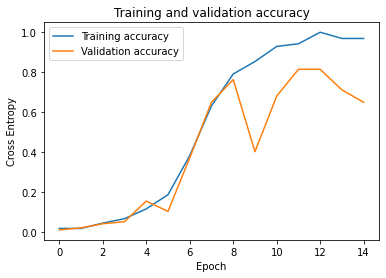

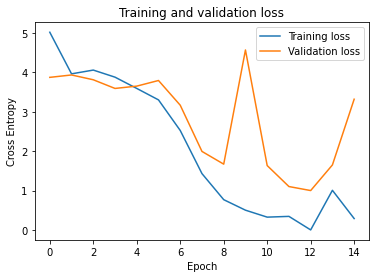

In [ ]:
plot_learning_curves(m5_sequential_model_train)

In [ ]:
m5_predicted_classes, m5_y_test_flatten = predict_classes(m5_sequential_model, y_test, X_testCNN)

(138,) (138,)


Found 102 correct labels


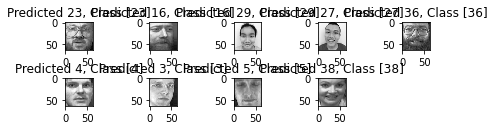

In [ ]:
correct_labels(m5_predicted_classes, m5_y_test_flatten, X_trainCNN)

Found 36 incorrect labels


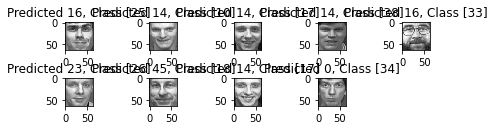

In [ ]:
incorrect_labels(m5_predicted_classes, m5_y_test_flatten, X_trainCNN)

========== CNN CLASSIFICATION REPORT ==========
              precision    recall  f1-score   support

     Class 0       0.50      1.00      0.67         3
     Class 1       1.00      1.00      1.00         3
     Class 2       1.00      1.00      1.00         3
     Class 3       1.00      1.00      1.00         3
     Class 4       1.00      1.00      1.00         3
     Class 5       1.00      1.00      1.00         3
     Class 6       1.00      1.00      1.00         3
     Class 7       1.00      1.00      1.00         3
     Class 8       1.00      0.67      0.80         3
     Class 9       1.00      0.67      0.80         3
    Class 10       0.00      0.00      0.00         3
    Class 11       0.50      1.00      0.67         3
    Class 12       0.75      1.00      0.86         3
    Class 13       1.00      1.00      1.00         3
    Class 14       0.21      1.00      0.35         3
    Class 15       0.00      0.00      0.00         3
    Class 16       0.27      1.00

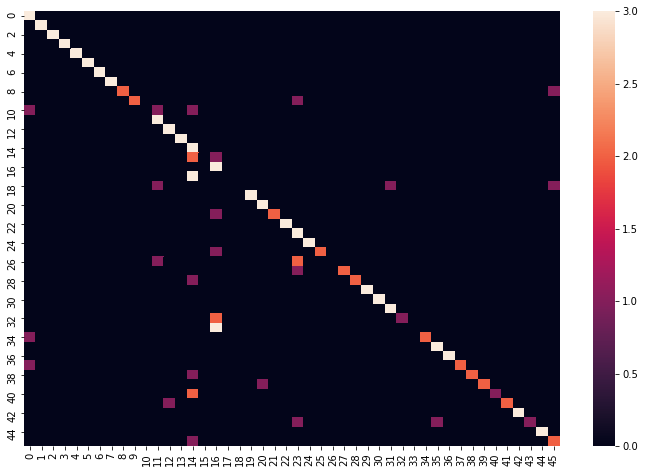

In [ ]:
produce_classification_report(num_classes, y_test, m5_predicted_classes)

#### Model 6 with RMSprop optimizer but con2d kernel size 5x5

In [ ]:
m6_sequential_model = model_define_compile3(opt_rmsprop, kSize[2])

Optimizer: <keras.optimizer_v2.rmsprop.RMSprop object at 0x7f433d695590>
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_134 (Conv2D)          (None, 64, 64, 32)        832       
_________________________________________________________________
leaky_re_lu_177 (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_134 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 32, 32, 64)        51264     
_________________________________________________________________
leaky_re_lu_178 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_135 (MaxPoolin (None, 16, 16, 64)        0         
______________________________________________

In [ ]:
m6_sequential_model_train = fit_model(m6_sequential_model)

Epoch 1/15
57/57 [==============================] - 7s 104ms/step - loss: 3.9144 - accuracy: 0.0222 - val_loss: 11.4364 - val_accuracy: 0.0103
Epoch 2/15
57/57 [==============================] - 6s 101ms/step - loss: 3.8363 - accuracy: 0.1022 - val_loss: 3.5327 - val_accuracy: 0.0928
Epoch 3/15
57/57 [==============================] - 6s 102ms/step - loss: 3.2953 - accuracy: 0.1644 - val_loss: 3.3497 - val_accuracy: 0.1443
Epoch 4/15
57/57 [==============================] - 6s 100ms/step - loss: 2.5474 - accuracy: 0.3289 - val_loss: 2.3703 - val_accuracy: 0.4433
Epoch 5/15
57/57 [==============================] - 6s 101ms/step - loss: 1.4356 - accuracy: 0.6489 - val_loss: 1.8061 - val_accuracy: 0.5464
Epoch 6/15
57/57 [==============================] - 6s 100ms/step - loss: 0.6204 - accuracy: 0.8133 - val_loss: 3.3282 - val_accuracy: 0.1856
Epoch 7/15
57/57 [==============================] - 6s 101ms/step - loss: 0.3607 - accuracy: 0.8933 - val_loss: 1.7700 - val_accuracy: 0.5773
Epoch

In [ ]:
test_model(m6_sequential_model)

5/5 [==============================] - 1s 135ms/step - loss: 1.0083 - accuracy: 0.8333
Test loss: 1.0083245038986206
Test accuracy: 0.8333333134651184


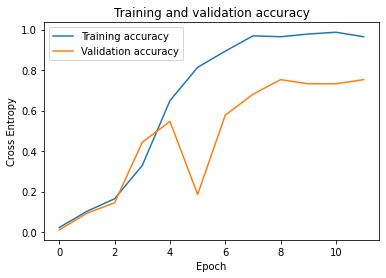

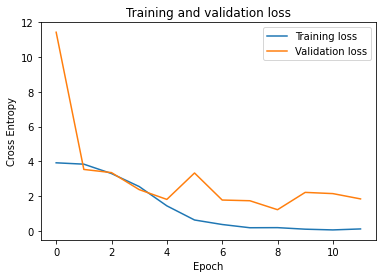

In [ ]:
plot_learning_curves(m6_sequential_model_train)

In [ ]:
m6_predicted_classes, m6_y_test_flatten = predict_classes(m6_sequential_model, y_test, X_testCNN)

(138,) (138,)


Found 115 correct labels


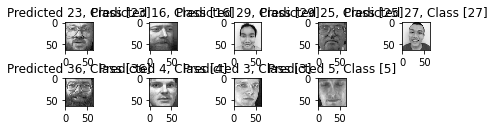

In [ ]:
correct_labels(m6_predicted_classes, m6_y_test_flatten, X_trainCNN)

Found 23 incorrect labels


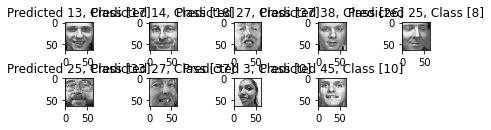

In [ ]:
incorrect_labels(m6_predicted_classes, m6_y_test_flatten, X_trainCNN)

========== CNN CLASSIFICATION REPORT ==========
              precision    recall  f1-score   support

     Class 0       0.40      0.67      0.50         3
     Class 1       1.00      1.00      1.00         3
     Class 2       1.00      0.67      0.80         3
     Class 3       0.75      1.00      0.86         3
     Class 4       1.00      1.00      1.00         3
     Class 5       1.00      1.00      1.00         3
     Class 6       1.00      1.00      1.00         3
     Class 7       1.00      1.00      1.00         3
     Class 8       1.00      0.33      0.50         3
     Class 9       1.00      1.00      1.00         3
    Class 10       1.00      0.33      0.50         3
    Class 11       1.00      1.00      1.00         3
    Class 12       1.00      1.00      1.00         3
    Class 13       0.60      1.00      0.75         3
    Class 14       0.75      1.00      0.86         3
    Class 15       0.00      0.00      0.00         3
    Class 16       1.00      1.00

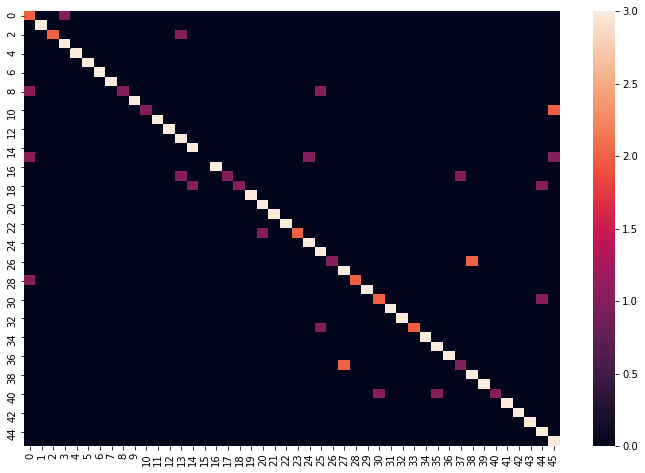

In [ ]:
produce_classification_report(num_classes, y_test, m6_predicted_classes)

#### Conclusion from Model 2,4,5 & 6 in comparing different kernel sizes.


> With different kernel size 1x1, 3x3, 5x5, 7x7, the testing accuracy are different - 


*   1x1 - 0.78 
*   3x3 - 0.93
*   5x5 - 0.83
*   7x7 - 0.74


#### Model 7 with RMSprop Optimizer but batch size = 16

In [ ]:
m7_sequential_model = model_define_compile(opt_rmsprop, num_classes)

Optimizer: <keras.optimizer_v2.rmsprop.RMSprop object at 0x7f433d695590>
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 64, 64, 32)        320       
_________________________________________________________________
leaky_re_lu_143 (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_144 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 16, 16, 64)        0         
______________________________________________

In [ ]:
m7_sequential_model_train = fit_model2(m7_sequential_model,16, 15)

Epoch 1/15
15/15 [==============================] - 3s 174ms/step - loss: 3.8546 - accuracy: 0.0267 - val_loss: 3.8317 - val_accuracy: 0.0515
Epoch 2/15
15/15 [==============================] - 2s 165ms/step - loss: 3.7400 - accuracy: 0.0489 - val_loss: 3.7915 - val_accuracy: 0.0309
Epoch 3/15
15/15 [==============================] - 2s 164ms/step - loss: 3.4561 - accuracy: 0.1289 - val_loss: 3.7542 - val_accuracy: 0.0722
Epoch 4/15
15/15 [==============================] - 2s 163ms/step - loss: 3.2440 - accuracy: 0.2044 - val_loss: 3.1691 - val_accuracy: 0.2062
Epoch 5/15
15/15 [==============================] - 2s 165ms/step - loss: 2.4729 - accuracy: 0.3600 - val_loss: 2.9619 - val_accuracy: 0.2577
Epoch 6/15
15/15 [==============================] - 2s 166ms/step - loss: 1.7604 - accuracy: 0.5644 - val_loss: 4.3103 - val_accuracy: 0.1856
Epoch 7/15
15/15 [==============================] - 2s 167ms/step - loss: 1.3483 - accuracy: 0.6800 - val_loss: 2.9841 - val_accuracy: 0.1237
Epoch 

In [ ]:
test_model(m7_sequential_model)

5/5 [==============================] - 0s 73ms/step - loss: 3.3529 - accuracy: 0.5217
Test loss: 3.352881908416748
Test accuracy: 0.52173912525177


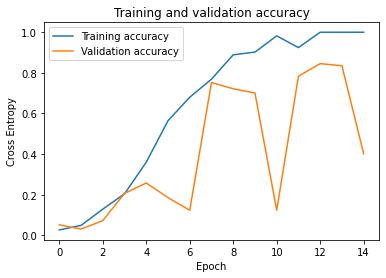

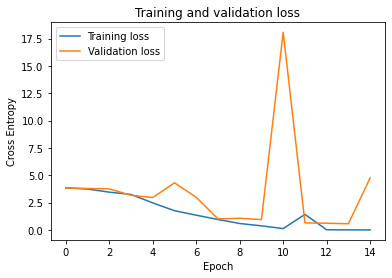

In [ ]:
plot_learning_curves(m7_sequential_model_train)

In [ ]:
m7_predicted_classes, m7_y_test_flatten = predict_classes(m7_sequential_model, y_test, X_testCNN)

(138,) (138,)


Found 71 correct labels


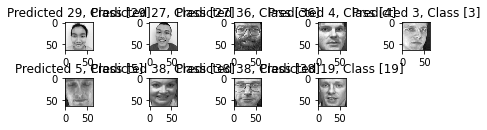

In [ ]:
correct_labels(m7_predicted_classes, m7_y_test_flatten, X_trainCNN)

Found 67 incorrect labels


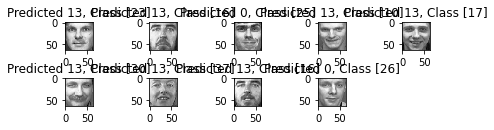

In [ ]:
incorrect_labels(m7_predicted_classes, m7_y_test_flatten, X_trainCNN)

========== CNN CLASSIFICATION REPORT ==========
              precision    recall  f1-score   support

     Class 0       0.43      1.00      0.60         3
     Class 1       1.00      1.00      1.00         3
     Class 2       1.00      0.67      0.80         3
     Class 3       1.00      1.00      1.00         3
     Class 4       1.00      1.00      1.00         3
     Class 5       1.00      1.00      1.00         3
     Class 6       0.00      0.00      0.00         3
     Class 7       1.00      0.67      0.80         3
     Class 8       0.00      0.00      0.00         3
     Class 9       0.00      0.00      0.00         3
    Class 10       0.00      0.00      0.00         3
    Class 11       1.00      0.33      0.50         3
    Class 12       1.00      0.67      0.80         3
    Class 13       0.06      1.00      0.11         3
    Class 14       1.00      0.67      0.80         3
    Class 15       0.00      0.00      0.00         3
    Class 16       0.00      0.00

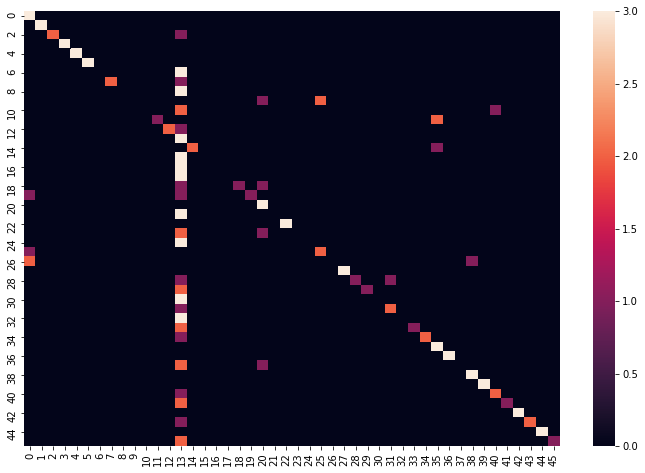

In [ ]:
produce_classification_report(num_classes, y_test, m7_predicted_classes)

#### Model 8 with RMSprop Optimizer but batch size = 32


In [ ]:
m8_sequential_model = model_define_compile(opt_rmsprop, num_classes)

Optimizer: <keras.optimizer_v2.rmsprop.RMSprop object at 0x7f433d695590>
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_114 (Conv2D)          (None, 64, 64, 32)        320       
_________________________________________________________________
leaky_re_lu_151 (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_114 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_152 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_115 (MaxPoolin (None, 16, 16, 64)        0         
______________________________________________

In [ ]:
m8_sequential_model_train = fit_model2(m8_sequential_model,32, 15)

Epoch 1/15
8/8 [==============================] - 3s 316ms/step - loss: 3.9223 - accuracy: 0.0178 - val_loss: 4.0301 - val_accuracy: 0.0206
Epoch 2/15
8/8 [==============================] - 2s 289ms/step - loss: 3.8410 - accuracy: 0.0356 - val_loss: 3.9917 - val_accuracy: 0.0309
Epoch 3/15
8/8 [==============================] - 2s 289ms/step - loss: 3.7452 - accuracy: 0.0667 - val_loss: 8.4772 - val_accuracy: 0.0000e+00
Epoch 4/15
8/8 [==============================] - 2s 288ms/step - loss: 4.1930 - accuracy: 0.0800 - val_loss: 3.7966 - val_accuracy: 0.0619
Epoch 5/15
8/8 [==============================] - 2s 289ms/step - loss: 3.5093 - accuracy: 0.0978 - val_loss: 3.6819 - val_accuracy: 0.0825
Epoch 6/15
8/8 [==============================] - 2s 290ms/step - loss: 3.2883 - accuracy: 0.2133 - val_loss: 4.3922 - val_accuracy: 0.0309
Epoch 7/15
8/8 [==============================] - 2s 291ms/step - loss: 3.1459 - accuracy: 0.2978 - val_loss: 3.0885 - val_accuracy: 0.2062
Epoch 8/15
8/8 [

In [ ]:
test_model(m8_sequential_model)

5/5 [==============================] - 0s 71ms/step - loss: 3.1968 - accuracy: 0.1377
Test loss: 3.196786403656006
Test accuracy: 0.13768115639686584


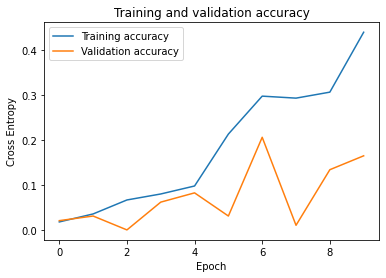

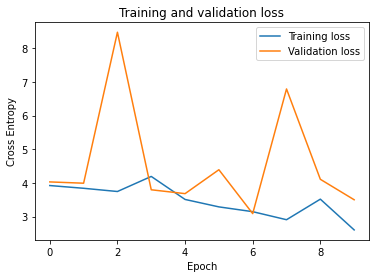

In [ ]:
plot_learning_curves(m8_sequential_model_train)

In [ ]:
m8_predicted_classes, m8_y_test_flatten = predict_classes(m8_sequential_model, y_test, X_testCNN)

(138,) (138,)


Found 18 correct labels


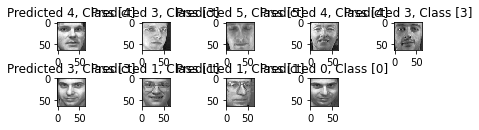

In [ ]:
correct_labels(m8_predicted_classes, m8_y_test_flatten, X_trainCNN)

Found 120 incorrect labels


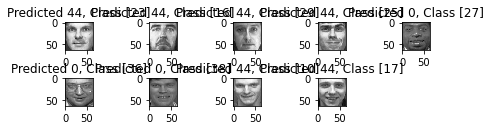

In [ ]:
incorrect_labels(m8_predicted_classes, m8_y_test_flatten, X_trainCNN)

========== CNN CLASSIFICATION REPORT ==========
              precision    recall  f1-score   support

     Class 0       0.06      1.00      0.12         3
     Class 1       1.00      1.00      1.00         3
     Class 2       1.00      0.67      0.80         3
     Class 3       1.00      1.00      1.00         3
     Class 4       1.00      1.00      1.00         3
     Class 5       1.00      1.00      1.00         3
     Class 6       0.00      0.00      0.00         3
     Class 7       0.00      0.00      0.00         3
     Class 8       0.00      0.00      0.00         3
     Class 9       0.00      0.00      0.00         3
    Class 10       0.00      0.00      0.00         3
    Class 11       0.00      0.00      0.00         3
    Class 12       0.00      0.00      0.00         3
    Class 13       0.00      0.00      0.00         3
    Class 14       0.00      0.00      0.00         3
    Class 15       0.00      0.00      0.00         3
    Class 16       0.00      0.00

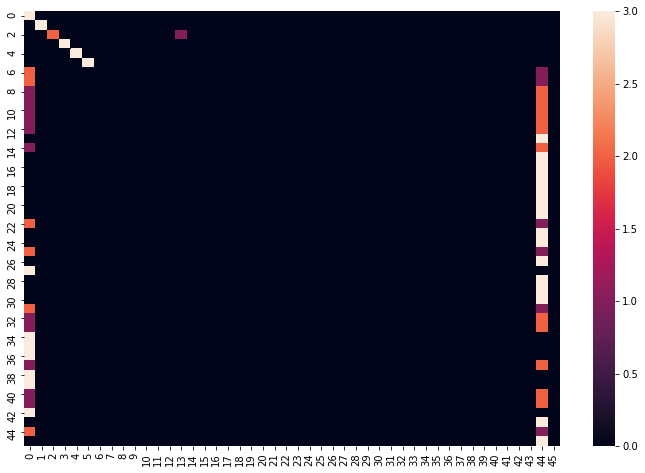

In [ ]:
produce_classification_report(num_classes, y_test, m8_predicted_classes)

#### Conclusion from Model 2, 7 & 8 in comparing different batch size.


> From these 3 models, as the batch size increase, the Test accuracy drop dramatically. 
*   Batch size 4 - Test accuracy 0.93 - Correct labels - 128
*   Batch size 16 - Test accuracy 0.52 - Correct labels - 79
*   Batch size 32 - Test accuracy 0.13 - Correct labels - 18

Thus, the batch size is significant




#### Model 9 with different number of layers


In [ ]:
m9_sequential_model = model_define_compile4(opt_rmsprop)

Optimizer: <keras.optimizer_v2.rmsprop.RMSprop object at 0x7f69b18d4d90>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________

In [ ]:
m9_sequential_model_train = fit_model(m9_sequential_model)

Epoch 1/15
57/57 [==============================] - 30s 17ms/step - loss: 3.8463 - accuracy: 0.0133 - val_loss: 3.8478 - val_accuracy: 0.0309
Epoch 2/15
57/57 [==============================] - 1s 11ms/step - loss: 3.8213 - accuracy: 0.0356 - val_loss: 3.7969 - val_accuracy: 0.0309
Epoch 3/15
57/57 [==============================] - 1s 11ms/step - loss: 3.5709 - accuracy: 0.1156 - val_loss: 3.4856 - val_accuracy: 0.0825
Epoch 4/15
57/57 [==============================] - 1s 11ms/step - loss: 3.2262 - accuracy: 0.1911 - val_loss: 3.1275 - val_accuracy: 0.2268
Epoch 5/15
57/57 [==============================] - 1s 10ms/step - loss: 2.7861 - accuracy: 0.2933 - val_loss: 2.8228 - val_accuracy: 0.3505
Epoch 6/15
57/57 [==============================] - 1s 11ms/step - loss: 1.9985 - accuracy: 0.4933 - val_loss: 2.5054 - val_accuracy: 0.4330
Epoch 7/15
57/57 [==============================] - 1s 10ms/step - loss: 1.2850 - accuracy: 0.6222 - val_loss: 2.1952 - val_accuracy: 0.5464
Epoch 8/15
5

In [ ]:
test_model(m9_sequential_model)

5/5 [==============================] - 0s 27ms/step - loss: 1.3539 - accuracy: 0.7464
Test loss: 1.35390305519104
Test accuracy: 0.7463768124580383


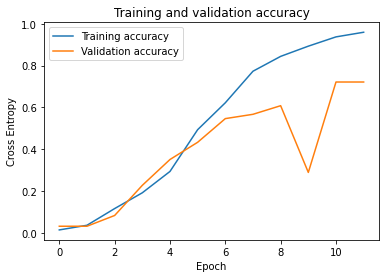

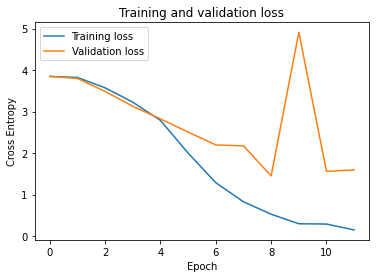

In [ ]:
plot_learning_curves(m9_sequential_model_train)

In [ ]:
m9_predicted_classes, m9_y_test_flatten = predict_classes(m9_sequential_model, y_test, X_testCNN)

(138,) (138,)


Found 103 correct labels


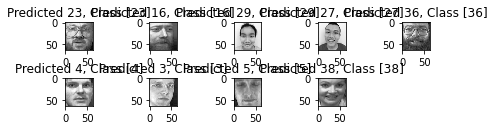

In [ ]:
correct_labels(m9_predicted_classes, m9_y_test_flatten, X_trainCNN)

Found 35 incorrect labels


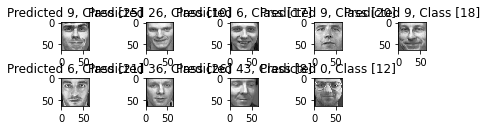

In [ ]:
incorrect_labels(m9_predicted_classes, m9_y_test_flatten, X_trainCNN)

========== CNN CLASSIFICATION REPORT ==========
              precision    recall  f1-score   support

     Class 0       0.33      0.67      0.44         3
     Class 1       1.00      1.00      1.00         3
     Class 2       1.00      1.00      1.00         3
     Class 3       1.00      1.00      1.00         3
     Class 4       1.00      1.00      1.00         3
     Class 5       0.75      1.00      0.86         3
     Class 6       0.19      1.00      0.32         3
     Class 7       1.00      0.67      0.80         3
     Class 8       0.00      0.00      0.00         3
     Class 9       0.33      1.00      0.50         3
    Class 10       0.00      0.00      0.00         3
    Class 11       1.00      0.33      0.50         3
    Class 12       1.00      0.67      0.80         3
    Class 13       1.00      0.67      0.80         3
    Class 14       1.00      0.67      0.80         3
    Class 15       0.00      0.00      0.00         3
    Class 16       1.00      1.00

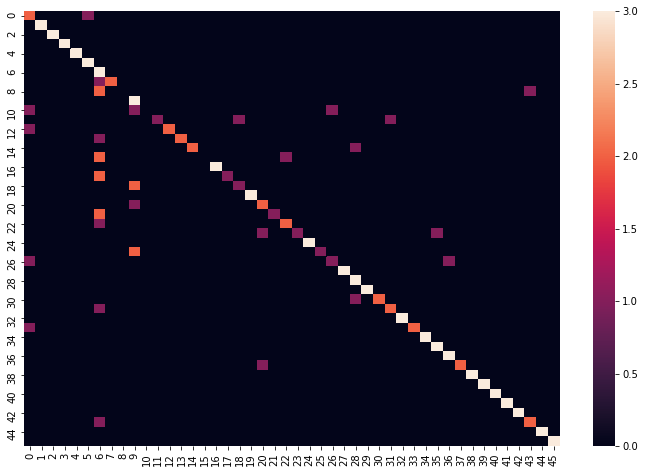

In [ ]:
produce_classification_report(num_classes, y_test, m9_predicted_classes)

#### Conclusion of Model 9
> The sudden spike and dip in validation loss as shown in Figure 5. This might be a sign of under fitting. Hence, we wouldn’t add any additional layer to the current proposed model architecture.

#### Model 10 with ResNet50, Freeze all layers 

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [ ]:
IMAGE_SIZE = [64, 64]
train_path = '/content/gdrive/MyDrive/Dataset/MLdatax11_Train'
test_path = '/content/gdrive/MyDrive/Dataset/MLdatax11_Test'

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# don't train existing weights
# fully frozen
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
# number of output classes
folders = glob.glob('/content/gdrive/MyDrive/Dataset/MLdatax11_Train/*')
len(folders)

46

In [ ]:
# Add layer
x = Dropout(0.5)(resnet.output)
x = Flatten()(x)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model10 = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
model10.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
model10.compile(
  loss='categorical_crossentropy',
  optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=0.001),
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 318 images belonging to 46 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 142 images belonging to 46 classes.


In [ ]:
# fit the model
r = model10.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=11,
  steps_per_epoch=len(training_set),
  validation_steps = len(test_set)
)

Epoch 1/11
10/10 [==============================] - 329s 30s/step - loss: 4.4024 - accuracy: 0.0220 - val_loss: 3.8811 - val_accuracy: 0.0634
Epoch 2/11
10/10 [==============================] - 6s 560ms/step - loss: 4.0545 - accuracy: 0.0189 - val_loss: 3.7748 - val_accuracy: 0.0634
Epoch 3/11
10/10 [==============================] - 5s 586ms/step - loss: 4.0202 - accuracy: 0.0440 - val_loss: 3.7343 - val_accuracy: 0.1056
Epoch 4/11
10/10 [==============================] - 6s 564ms/step - loss: 3.9625 - accuracy: 0.0472 - val_loss: 3.7008 - val_accuracy: 0.0634
Epoch 5/11
10/10 [==============================] - 6s 568ms/step - loss: 3.8951 - accuracy: 0.0377 - val_loss: 3.6914 - val_accuracy: 0.1197
Epoch 6/11
10/10 [==============================] - 6s 562ms/step - loss: 3.8580 - accuracy: 0.0472 - val_loss: 3.6502 - val_accuracy: 0.1197
Epoch 7/11
10/10 [==============================] - 5s 557ms/step - loss: 3.8402 - accuracy: 0.0692 - val_loss: 3.6243 - val_accuracy: 0.1620
Epoch 

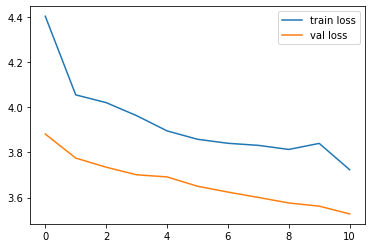

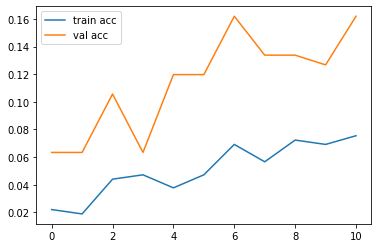

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
test_model10 = model10.evaluate(test_set)

5/5 [==============================] - 2s 306ms/step - loss: 3.5277 - accuracy: 0.1620


In [ ]:
pred_model10 = model10.predict(test_set)
#print(pred_model10)
pred_model10 = np.argmax(pred_model10,axis=1)
#print(pred_model10)

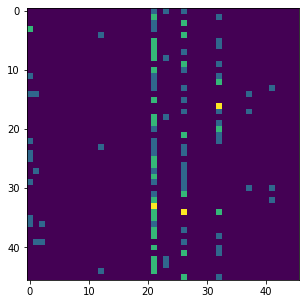

In [ ]:
from sklearn.metrics import confusion_matrix
plt.figure(1, figsize=(5,5))
model10_cm = confusion_matrix(test_set.classes, pred_model10)
#print(model10_cm)
plt.imshow(model10_cm)

#### Model 11 with ResNet50, Freeze first 50 layers 

In [ ]:
IMAGE_SIZE = [64, 64]
train_path = '/content/gdrive/MyDrive/Dataset/MLdatax11_Train'
test_path = '/content/gdrive/MyDrive/Dataset/MLdatax11_Test'

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# partial frozen
freeze_till_layer = 50
for layer in resnet.layers[:freeze_till_layer]:
    layer.trainable = False

In [ ]:
folders = glob.glob('/content/gdrive/MyDrive/Dataset/MLdatax11_Train/*')
len(folders)

46

In [ ]:
# Add layer
x = Flatten()(resnet.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model11 = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
model11.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model11.compile(
  loss='categorical_crossentropy',
  optimizer='RMSprop',
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True, vertical_flip= True )
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 318 images belonging to 46 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 142 images belonging to 46 classes.


In [ ]:
# fit the model
r = model11.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=11,
  steps_per_epoch=len(training_set),
  validation_steps = len(test_set)
)

Epoch 1/11
10/10 [==============================] - 19s 753ms/step - loss: 8.1105 - accuracy: 0.0220 - val_loss: 913.0085 - val_accuracy: 0.0211
Epoch 2/11
10/10 [==============================] - 6s 618ms/step - loss: 8.8621 - accuracy: 0.0409 - val_loss: 12429.1064 - val_accuracy: 0.0211
Epoch 3/11
10/10 [==============================] - 6s 617ms/step - loss: 7.9814 - accuracy: 0.0220 - val_loss: 3032.5691 - val_accuracy: 0.0211
Epoch 4/11
10/10 [==============================] - 6s 607ms/step - loss: 6.2983 - accuracy: 0.0346 - val_loss: 1035.1130 - val_accuracy: 0.0493
Epoch 5/11
10/10 [==============================] - 6s 611ms/step - loss: 5.9278 - accuracy: 0.0314 - val_loss: 2252.2456 - val_accuracy: 0.0211
Epoch 6/11
10/10 [==============================] - 6s 617ms/step - loss: 6.8399 - accuracy: 0.0314 - val_loss: 5861.0835 - val_accuracy: 0.0211
Epoch 7/11
10/10 [==============================] - 6s 582ms/step - loss: 5.6409 - accuracy: 0.0220 - val_loss: 8503.5820 - val_a

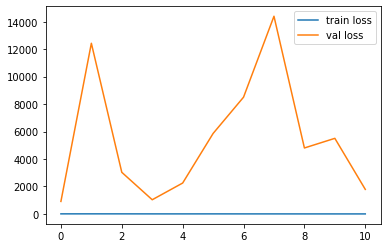

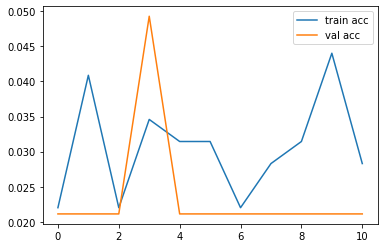

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
test_model11 = model11.evaluate(test_set)

5/5 [==============================] - 2s 234ms/step - loss: 1790.5422 - accuracy: 0.0211


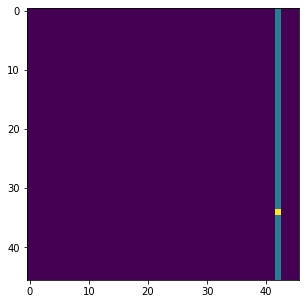

In [ ]:
pred_model11 = model11.predict(test_set)
pred_model11 = np.argmax(pred_model11,axis=1)
plt.figure(1, figsize=(5,5))
model11_cm = confusion_matrix(test_set.classes, pred_model11)
plt.imshow(model11_cm)

#### Model 12 with ResNet50, Freeze first 100 layers

In [ ]:
IMAGE_SIZE = [64, 64]
train_path = '/content/gdrive/MyDrive/Dataset/MLdatax11_Train'
test_path = '/content/gdrive/MyDrive/Dataset/MLdatax11_Test'

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# partial frozen
freeze_till_layer = 100
for layer in resnet.layers[:freeze_till_layer]:
    layer.trainable = False

In [ ]:
folders = glob.glob('/content/gdrive/MyDrive/Dataset/MLdatax11_Train/*')
len(folders)

46

In [ ]:
# Add layer
x = Flatten()(resnet.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model12 = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
model12.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model12.compile(
  loss='categorical_crossentropy',
  optimizer='RMSprop',
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True, vertical_flip= True )

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 318 images belonging to 46 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 142 images belonging to 46 classes.


In [ ]:
# fit the model
r = model12.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=11,
  steps_per_epoch=len(training_set),
  validation_steps = len(test_set)
)

Epoch 1/11
10/10 [==============================] - 14s 694ms/step - loss: 7.9191 - accuracy: 0.0220 - val_loss: 115.5124 - val_accuracy: 0.0211
Epoch 2/11
10/10 [==============================] - 6s 535ms/step - loss: 8.1054 - accuracy: 0.0220 - val_loss: 147.0900 - val_accuracy: 0.0211
Epoch 3/11
10/10 [==============================] - 6s 606ms/step - loss: 6.3685 - accuracy: 0.0283 - val_loss: 91.2431 - val_accuracy: 0.0211
Epoch 4/11
10/10 [==============================] - 6s 615ms/step - loss: 6.7914 - accuracy: 0.0126 - val_loss: 127.4614 - val_accuracy: 0.0211
Epoch 5/11
10/10 [==============================] - 6s 557ms/step - loss: 5.6110 - accuracy: 0.0252 - val_loss: 119.3316 - val_accuracy: 0.0211
Epoch 6/11
10/10 [==============================] - 6s 622ms/step - loss: 5.3553 - accuracy: 0.0283 - val_loss: 1083.7069 - val_accuracy: 0.0211
Epoch 7/11
10/10 [==============================] - 6s 617ms/step - loss: 5.2691 - accuracy: 0.0314 - val_loss: 2397.3254 - val_accurac

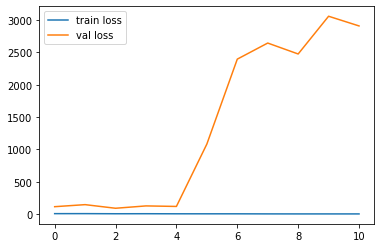

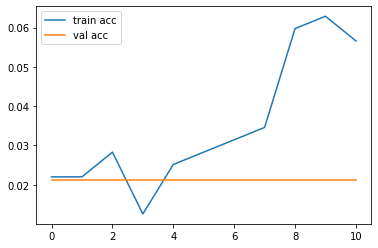

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
test_model12 = model12.evaluate(test_set)

5/5 [==============================] - 2s 361ms/step - loss: 2910.6404 - accuracy: 0.0211


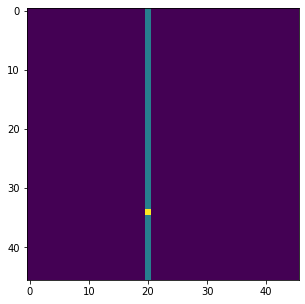

In [ ]:
pred_model12 = model12.predict(test_set)
pred_model12 = np.argmax(pred_model12,axis=1)
plt.figure(1, figsize=(5,5))
model12_cm = confusion_matrix(test_set.classes, pred_model12)
plt.imshow(model12_cm)

#### Model 13 with ResNet50, No Freeze

In [ ]:
IMAGE_SIZE = [64, 64]
train_path = '/content/gdrive/MyDrive/Dataset/MLdatax11_Train'
test_path = '/content/gdrive/MyDrive/Dataset/MLdatax11_Test'

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# No freeze
resnet.trainable = True

In [ ]:
folders = glob.glob('/content/gdrive/MyDrive/Dataset/MLdatax11_Train/*')
len(folders)

46

In [ ]:
# Add layer
x = Flatten()(resnet.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model13 = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
model13.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model13.compile(
  loss='categorical_crossentropy',
  optimizer='RMSprop',
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True, vertical_flip= True )

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 318 images belonging to 46 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 142 images belonging to 46 classes.


In [ ]:
# fit the model
r = model13.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=11,
  steps_per_epoch=len(training_set),
  validation_steps = len(test_set), callbacks= [es]
)

Epoch 1/11
10/10 [==============================] - 20s 777ms/step - loss: 9.0344 - accuracy: 0.0818 - val_loss: 1026.2394 - val_accuracy: 0.0211
Epoch 2/11
10/10 [==============================] - 6s 629ms/step - loss: 6.6455 - accuracy: 0.1541 - val_loss: 438745.4375 - val_accuracy: 0.0211
Epoch 3/11
10/10 [==============================] - 6s 578ms/step - loss: 4.8585 - accuracy: 0.2107 - val_loss: 17675.6035 - val_accuracy: 0.0211
Epoch 4/11
10/10 [==============================] - 6s 597ms/step - loss: 4.7692 - accuracy: 0.3396 - val_loss: 68988.1172 - val_accuracy: 0.0211
Epoch 00004: early stopping


In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
test_model13 = model13.evaluate(test_set)

In [ ]:
pred_model13 = model13.predict(test_set)
pred_model13 = np.argmax(pred_model13,axis=1)
plt.figure(1, figsize=(5,5))
model13_cm = confusion_matrix(test_set.classes, pred_model13)
plt.imshow(model13_cm)

#### Model 14 with ResNet50, No freeze, no weight 

In [ ]:
IMAGE_SIZE = [64, 64]
train_path = '/content/gdrive/MyDrive/Dataset/MLdatax11_Train'
test_path = '/content/gdrive/MyDrive/Dataset/MLdatax11_Test'

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights=None, include_top=False)

In [ ]:
resnet.trainable = True

In [ ]:
# number of output classes
folders = glob.glob('/content/gdrive/MyDrive/Dataset/MLdatax11_Train/*')
len(folders)

46

In [ ]:
# Add layer
x = Dropout(0.5)(resnet.output)
x = Flatten()(x)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model14 = Model(inputs=resnet.input, outputs=prediction)

In [ ]:
model14.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model14.compile(
  loss='categorical_crossentropy',
  optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=0.001),
  metrics=['accuracy']
)

In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 318 images belonging to 46 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 142 images belonging to 46 classes.


In [ ]:
# fit the model
r = model14.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=11,
  steps_per_epoch=len(training_set),
  validation_steps = len(test_set)
)

Epoch 1/11
10/10 [==============================] - 21s 802ms/step - loss: 15.5157 - accuracy: 0.0220 - val_loss: 3.8666 - val_accuracy: 0.0211
Epoch 2/11
10/10 [==============================] - 6s 660ms/step - loss: 7.1143 - accuracy: 0.0283 - val_loss: 3.8579 - val_accuracy: 0.0211
Epoch 3/11
10/10 [==============================] - 6s 631ms/step - loss: 8.5931 - accuracy: 0.0472 - val_loss: 3.8859 - val_accuracy: 0.0211
Epoch 4/11
10/10 [==============================] - 6s 667ms/step - loss: 9.4135 - accuracy: 0.0189 - val_loss: 3.8894 - val_accuracy: 0.0282
Epoch 5/11
10/10 [==============================] - 6s 629ms/step - loss: 9.1928 - accuracy: 0.0377 - val_loss: 3.9197 - val_accuracy: 0.0211
Epoch 6/11
10/10 [==============================] - 6s 664ms/step - loss: 7.7964 - accuracy: 0.0629 - val_loss: 1178.4333 - val_accuracy: 0.0211
Epoch 7/11
10/10 [==============================] - 6s 666ms/step - loss: 5.7129 - accuracy: 0.0786 - val_loss: 1393.2939 - val_accuracy: 0.021

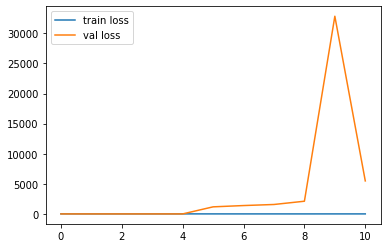

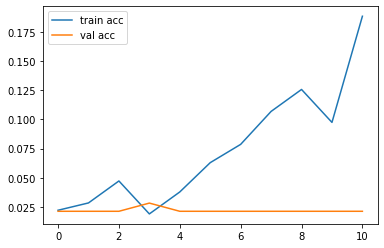

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
test_model14 = model14.evaluate(test_set)

5/5 [==============================] - 2s 297ms/step - loss: 5485.7666 - accuracy: 0.0211


In [ ]:
pred_model14 = model14.predict(test_set)
pred_model14 = np.argmax(pred_model14,axis=1)

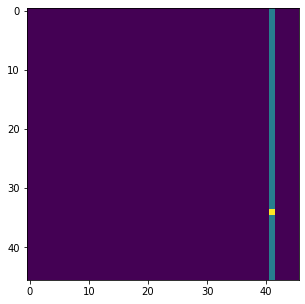

In [ ]:
from sklearn.metrics import confusion_matrix
plt.figure(1, figsize=(5,5))
model14_cm = confusion_matrix(test_set.classes, pred_model14)
plt.imshow(model14_cm)

#### Conclusion from Model 10,11,12,13,14 of ResNet50
> ResNet50 model is implemented, and it will be used for transfer learning purposes. The transfer learning process involves applying the knowledge that a neural network has acquired from one task to another [16]. Also, we tried different approaches like fully freezing, partial freezing and no freezing layers to determine which work better. However, none of them work well with our dataset. It may be caused by absence of a dropout layer. The ResNet50 has been trained on a huge size dataset. When we use ResNet50 to train our small size dataset, the model will be under fitting very easily. Further investigation is needed.

Thus, the most significant variables for convolutional neural network are: 

*  Batch Size
*  Learning Rate
*  Kernel Size


##Conclusion

#### Based on all models that we have applied:


1.   Linear Discriminant Analysis
2.   Logistic Regression
3.   Gaussian Naive Bayes
4.   K-Nearest Neighbors 
5.   Decision Tree
6.   Support Vector Classification
7.   Convolutional Neural Network

#### We have come to a conclusion that Linear Discriminant Analysis gives the best results with a very high precision of 0.97. The reason we choose this model is because it gives a relatively high accurate results.

As a result, we discovered that our system was successful in recognizing faces based on the input provided during the testing stage. However, additional progress may be made by gathering more dataset images and identifying and implementing many other critical variables, as well as fine-tuning using more CNN models.